# Master overview
This master overview contains all graphs used in the final thesis, to make sure everything was trained and tested on the same data.

In [47]:
# utils
from util import evaluate_no_cv, calculate_auc_and_plot, get_epitope_df, get_features, fix_test, \
    evaluate_seperate_chains, get_columns_starting_with, get_counts, plot_scores

# distance measures
from util import ProximityForestClassifier

# distance functions
from util import calculate_tcr_dist2, calculate_tcr_dist2_cached, calculate_tcr_dist_multiple_chains, \
    calculate_tcr_dist, multi_dist, levenstein_distance, multi_lev, calculate_approx_distance, nan_hamming
from util import levenstein_distance
from util import calculate_approx_distance_or
from util import compose_all

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline

# own models
from CustomForest import RandomForest as CustomForest
from util import ProximityForestClassifier, KNNString

# other
import numpy as np
import pandas as pd
from datetime import datetime
import os

# models
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [48]:
models_to_evaluate = []

In [49]:
# train/test data
folds = 5
epitope = "GILGFVFTL"
species = "HomoSapiens"
descr = "imputation-constant-numbers"

dataset_size = 50  # typically 50, 100, 200, 500, 1000, 2000, 5000 or None (None = all data)

data_per_fold = []
df_size = 0


def update_data_per_fold(dataset_size, epitope_=None, fixed_test_size=True, max_samples=None):
    global data_per_fold, df_size, epitope, species, folds

    epitope = epitope_ if epitope_ is not None else epitope

    df = get_epitope_df(epitope, species=species)

    if fixed_test_size:
        # for fixed test size (during the different size runs when sampling a few instances)
        df, test = train_test_split(df, test_size=0.2, random_state=0)
        test = test.sample(400, random_state=0)

    if max_samples is not None and len(df) > max_samples:
        df = df.sample(max_samples, random_state=0)

    # test.dropna(inplace=True)
    # split test df into folds
    # test_folds = np.array_split(test, folds)
    # test = test.sample(100, random_state=0)

    df = df.sample(dataset_size, random_state=0) if dataset_size is not None else df
    df_size = len(df)

    data_per_fold = []
    for seed in range(folds):
        fold_data = {"seed": seed,
                     "epitope": epitope,
                     "species": species,
                     "df_size": df_size, }

        train_with_nan, test_with_nan = train_test_split(df, test_size=0.2, random_state=seed)

        # # for fixed test size (during the different size runs)
        # test_with_nan = test_folds[seed] # actually no nan, but no problem
        if fixed_test_size:
            test_with_nan = test  # same test set for all folds

        test = test_with_nan.dropna()

        x_missing = train_with_nan.isna().any(axis=1)

        # with nan in train set
        x = get_features(train_with_nan)
        y = train_with_nan['reaction']

        # print the name of all columns in x that contain nan

        x_missing_test = test_with_nan.isna().any(axis=1)
        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        x_test_missing = x_test.isna().any(axis=1)

        y_test = test['reaction']

        alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(train_with_nan)

        assert len(x) == len(x_missing) == len(y)
        assert len(x_test) == len(x_test_missing) == len(y_test)

        fold_data["nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'x_missing': x_missing,
                            'x_missing_test': x_missing_test, 'x_original': train_with_nan,
                            'x_test_original': test,
                            "train_alpha_only": alpha_only_count_pos, "train_beta_only": beta_only_count_pos,
                            "train_both": both_count_pos, "train_non": non_count_pos, 'train_total': len(x),
                            'test_total': len(x_test)}

        # without nan in train set
        train_without_nan = train_with_nan.dropna()
        x = get_features(train_without_nan)
        y = train_without_nan['reaction']

        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        y_test = test['reaction']

        assert len(x) == len(y)
        assert len(x_test) == len(y_test)

        fold_data["no_nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'train_total': len(x),
                               'test_total': len(x_test), 'train_both': len(train_without_nan), 'train_non': 0,
                               'x_original': train_without_nan, 'x_test_original': test,
                               'train_alpha_only': 0, 'train_beta_only': 0}

        data_per_fold.append(fold_data)

    # print train and test size for seed 0 (nan and no_nan)
    nan_data = data_per_fold[0]["nan"]
    no_nan_data = data_per_fold[0]["no_nan"]
    print(f"Nan: train: {len(nan_data['x'])}, test: {len(nan_data['x_test'])}")
    print(f"No Nan: train: {len(no_nan_data['x'])}, test: {len(no_nan_data['x_test'])}")

In [50]:
def evaluate_model(model_description):
    """
    model description is a dict with the following keys:
    - name*: name of the model
    - model*: the model
    - imputer: the imputer to use
    - chain: 'both', 'alpha', 'beta' or 'seperate'. In cas of 'seperate', model_alpha and model_beta must be defined instead of model
    - drop_train_na: if True, all rows with nan in the train set are dropped
    - missing_indicator: if True, a missing indicator is added as feature
    - columns_to_use: list of columns to use (CDR, V, J)
    - extract_features: if False, the original columns are used and no features are extracted
    """
    global data_per_fold

    assert "name" in model_description
    assert "model" in model_description

    scores = pd.DataFrame()

    num_folds = len(data_per_fold)
    for i in range(num_folds):

        model_train_nan = not model_description.get("drop_train_na", False)
        data_name = "nan" if model_train_nan else "no_nan"

        chain = model_description.get("chain", "both")
        assert chain in ["both", "alpha", "beta", "seperate"]

        # get the precomputed dataset for this fold (either the version with nan or without nan
        fold_data = data_per_fold[i]
        fold_dataset = fold_data[data_name]
        x = fold_dataset["x"].copy()
        y = fold_dataset["y"].copy()
        x_test = fold_dataset["x_test"].copy()
        y_test = fold_dataset["y_test"].copy()

        columns_to_use = model_description.get("columns_to_use", None)

        extract_features = model_description.get("extract_features", True)

        # set the columns_to_use if only specific gene features are used
        gene_features = model_description.get("gene_features", None)
        if gene_features is not None:
            assert gene_features in ["FV", "F", "V", "F+V", "FV+F+V"]  #, "CDR_only"]

            column_map = {'F': ['V_family', 'J_family'],
                          'V': ['V_version', 'J_version'],
                          'FV': ['V', 'J']}
            column_map['F+V'] = column_map['F'] + column_map['V']
            column_map['FV+F+V'] = column_map['FV'] + column_map['F'] + column_map['V']
            # add CDR3 to all
            for key in column_map:
                column_map[key].append('CDR3')

            columns_to_use = column_map[gene_features]

        # if there needs to be other columns or no features need to be extracted, the pre-computed features won't work
        if columns_to_use is not None or not extract_features:
            if columns_to_use is None:
                columns_to_use = ["CDR3", "V", "J"]

            # recreate train data
            x_original = fold_dataset["x_original"]
            x_test_original = fold_dataset["x_test_original"]

            x = get_features(x_original, columns=columns_to_use, extract_features=extract_features)

            x_test = get_features(x_test_original, columns=columns_to_use, test=True, extract_features=extract_features)
            x_test = fix_test(x_test, x.columns)
            x_test.dropna(inplace=True)

        # add missing indicator if needed
        missing_indicator = model_description.get("missing_indicator", False)
        if missing_indicator:
            x_missing = fold_dataset["x_missing"]
            x_missing_test = fold_dataset["x_missing_test"]
            x["missing"] = x_missing
            x_test["missing"] = x_missing_test

        # get only alpha or beta chain if needed
        if chain == "alpha" or chain == "beta":
            x = get_columns_starting_with(x, f'{chain}_')
            x_test = get_columns_starting_with(x_test, f'{chain}_')

        model_imputer = model_description.get("imputer", None)

        separate_chains = chain == "seperate"

        try:
            if separate_chains:
                model_alpha = model_description["model_alpha"]
                model_beta = model_description["model_beta"]
                auc = evaluate_seperate_chains(model_alpha, model_beta, x, y, x_test, y_test, model_imputer)
            else:
                model = model_description["model"]
                if model_imputer is not None:
                    model = Pipeline([('imputer', model_imputer), ('model', model)])
                    model_imputer = None
                auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)

            # add the scores to the dataframe
            index = len(scores)
            scores.loc[index, 'model'] = model_description['name']
            scores.loc[index, 'auc'] = auc
            scores.loc[index, 'model_train_nan'] = model_train_nan
            scores.loc[index, 'imputer'] = model_imputer.__class__.__name__ if model_imputer is not None else None
            scores.loc[index, 'chain'] = chain
            scores.loc[index, 'group'] = model_description['group']

            scores.loc[index, 'seed'] = fold_data["seed"]
            scores.loc[index, 'epitope'] = fold_data["epitope"]
            scores.loc[index, 'species'] = fold_data["species"]

            scores.loc[index, 'train_alpha_only'] = fold_dataset["train_alpha_only"]
            scores.loc[index, 'train_beta_only'] = fold_dataset["train_beta_only"]
            scores.loc[index, 'train_both'] = fold_dataset["train_both"]
            scores.loc[index, 'train_non'] = fold_dataset["train_non"]
            scores.loc[index, 'train_total'] = fold_dataset["train_total"]
            scores.loc[index, 'test_total'] = fold_dataset["test_total"]
            scores.loc[index, 'df_size'] = fold_data["df_size"]

            scores.loc[index, 'gene_features'] = gene_features
            scores.loc[index, 'missing_indicator'] = missing_indicator

            # print the row
            # print(scores.loc[index])
            # print(f"AUC(m={model_description['name']}, s={seed}, train_na={int(model_train_nan)}): {auc}")
            print(auc)

        except Exception as e:
            print(f"Error: {e}")
            raise e  # for debugging
            continue

    return scores

In [51]:
def evaluate_model_list(models_to_evaluate):
    assert len(models_to_evaluate) > 0, "No models to evaluate"

    start_time = datetime.now()
    timestamp = start_time.strftime("%Y%m%d-%H%M%S")
    # create a directory in outputs to save the files to
    global epitope, df_size, descr
    output_dir = f"outputs/model-evaluations-{timestamp}-{epitope}-{df_size}-{descr}"
    os.makedirs(output_dir, exist_ok=True)

    output_log = f"{output_dir}/log.txt"
    with open(output_log, 'w') as f:
        f.write(f"Started at {start_time}\n\n")
        f.write(f"Models to evaluate: {len(models_to_evaluate)}\n\n")
        for i, model in enumerate(models_to_evaluate):
            f.write(f"{i + 1}/{len(models_to_evaluate)}: {model['name']}\n")
            f.write(f"{model}\n\n")

    scores = pd.DataFrame()
    for i, model in enumerate(models_to_evaluate):
        print(f"\nEvaluating model {i + 1}/{len(models_to_evaluate)}")
        print(model)
        model_scores = evaluate_model(model)

        model_scores['test_nr'] = i + 1
        model_scores.to_csv(f"{output_dir}/{i + 1}-{model['name']}.csv")

        scores = pd.concat([scores, model_scores])
    # write to csv
    end_time = datetime.now()

    time_taken = end_time - start_time
    timestamp = end_time.strftime("%Y%m%d-%H%M%S")
    scores.to_csv(f"{output_dir}/scores-{timestamp}.csv")

    plot_scores(scores, "All models", output_file=f"{output_dir}/all-models.png", hue_group_diff=False)

    # create a directory 'groups'
    groups_dir = f"{output_dir}/groups"
    os.makedirs(groups_dir, exist_ok=True)
    # for each group in the scores, save a csv with the scores for that group
    for group in scores['group'].unique():
        group_scores = scores[scores['group'] == group]

        # always add the baseline group
        if group != 'baseline':
            baseline_scores = scores[scores['group'] == 'baseline']
            group_scores = pd.concat([baseline_scores, group_scores])

        group_scores.to_csv(f"{groups_dir}/{group}.csv")
        plot_scores(group_scores, group, output_file=f"{groups_dir}/{group}.png", hue_group_diff=False)

    print(f'Finished evaluating {len(models_to_evaluate)} models at {timestamp} in {time_taken} seconds')

    with open(output_log, 'a') as f:
        f.write(f"Finished at {end_time}\n")
        f.write(f"Time taken: {time_taken}\n")
        f.write(f"Saved scores to {output_dir}\n")
        f.write(f"Saved all scores to {output_dir}/scores-{timestamp}.csv\n")
        f.write(f"Saved group scores to {groups_dir}\n")
        f.write(f"Saved all group scores to {groups_dir}/all-models.png\n")
        f.write(f"Saved all models to {output_dir}/all-models.png\n")
        f.write(f"Saved log to {output_log}\n")

    return scores, f"{output_dir}/scores-{timestamp}.csv"

In [52]:
# imputers
zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
most_freq_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [7]:
% % script echo skipping

# baseline (random forest, nans dropped in train)
baseline = {
    'name': 'Random Forest (NaNs dropped in train)',
    'model': RandomForestClassifier(random_state=0),
    'drop_train_na': True,
    'group': 'baseline',
}
models_to_evaluate.append(baseline)

UsageError: Line magic function `%` not found.


In [8]:
% % script echo skipping

# random forest imputations
rf_zero_imputed = {
    'name': 'Random Forest (Zero imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_mean_imputed = {
    'name': 'Random Forest (Mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'rf_imputations'
}

rf_most_freq_imputed = {
    'name': 'Random Forest (Most frequent imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': most_freq_imputer,
    'group': 'rf_imputations'
}

rf_median_imputed = {
    'name': 'Random Forest (Median imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': median_imputer,
    'group': 'rf_imputations'
}

rf_imputation_models = [rf_zero_imputed, rf_mean_imputed, rf_most_freq_imputed, rf_median_imputed]
models_to_evaluate.extend(rf_imputation_models)

Couldn't find program: 'echo'


In [9]:
% % script echo skipping

rf_impute_0 = {
    'name': 'Random Forest (0 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_impute_10 = {
    'name': 'Random Forest (10 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=10),
    'group': 'rf_imputations'
}

rf_impute_100 = {
    'name': 'Random Forest (100 imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=100),
    'group': 'rf_imputations'
}

models_to_evaluate.extend([rf_impute_0, rf_impute_10, rf_impute_100])

Couldn't find program: 'echo'


In [10]:
% % script echo skipping

# knn imputers
rf_knn_imputed_1 = {
    'name': 'Random Forest (KNN imputed, k=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=1),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_5 = {
    'name': 'Random Forest (KNN imputed, k=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=5),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_15 = {
    'name': 'Random Forest (KNN imputed, k=10)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=10),
    'group': 'rf_knn_imputations'
}

rf_knn_imputation_models = [rf_knn_imputed_1, rf_knn_imputed_5, rf_knn_imputed_15]
models_to_evaluate.extend(rf_knn_imputation_models)

Couldn't find program: 'echo'


In [11]:
% % script echo skipping

# iterative imputations
rf_iterative_imputed_1 = {
    'name': 'Random Forest (Iterative imputed, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_5 = {
    'name': 'Random Forest (Iterative imputed, max_iter=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=5),
    'group': 'rf_iterative_imputations'
}

# rf_iterative_imputed_10 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=10)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=10),
#     'group': 'rf_iterative_imputations'
# }
#
# rf_iterative_imputed_15 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=15)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=15),
#     'group': 'rf_iterative_imputations'
# }

# rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5, rf_iterative_imputed_10, rf_iterative_imputed_15]
rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5]
models_to_evaluate.extend(rf_iterative_imputation_models)

Couldn't find program: 'echo'


In [12]:
% % script echo skipping

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# iterative imputer with RandomForestRegressor, KNeighborsRegressor and MLP
# max_iter=1

rf_iterative_imputed_rfr = {
    'name': 'RF (Iterative imputed, RandomForestRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=RandomForestRegressor(random_state=0)),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_knr = {
    'name': 'RF (Iterative imputed, KNeighborsRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=KNeighborsRegressor()),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_mlp = {
    'name': 'RF (Iterative imputed, MLPRegressor, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1, estimator=MLPRegressor(random_state=0)),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputation_models = [rf_iterative_imputed_rfr, rf_iterative_imputed_knr, rf_iterative_imputed_mlp]
models_to_evaluate.extend(rf_iterative_imputation_models)

Couldn't find program: 'echo'


In [13]:
% % script echo skipping

# knn classifier
knn_classifier_mean_imputed = {
    'name': 'KNN Classifier (mean imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': mean_imputer
}

knn_classifier_knn_imputed = {
    'name': 'KNN Classifier (KNN imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': impute.KNNImputer()
}

knn_models = [knn_classifier_mean_imputed, knn_classifier_knn_imputed]
models_to_evaluate.extend(knn_models)

Couldn't find program: 'echo'


In [14]:
% % script echo skipping

# missing indicator imputations
# same models as above, but with missing indicator
rf_imputation_models_with_missing_indicator = []
for model in rf_imputation_models:
    model_with_missing_indicator = model.copy()
    model_with_missing_indicator['name'] += " (with missing indicator)"
    model_with_missing_indicator['missing_indicator'] = True
    model_with_missing_indicator['group'] = 'rf_imputations_with_missing_indicator'
    rf_imputation_models_with_missing_indicator.append(model_with_missing_indicator)

models_to_evaluate.extend(rf_imputation_models_with_missing_indicator)

Couldn't find program: 'echo'


In [15]:
% % script echo skipping

# gradient boosting classifiers
hist_gradient_boosting = {
    'name': 'HistGradientBoosting',
    'model': HistGradientBoostingClassifier(random_state=0),
    'group': 'gradient_boosting'
}

xgboost = {
    'name': 'XGBoost',
    'model': XGBClassifier(random_state=0),
    'group': 'gradient_boosting'
}

lightgbm = {
    'name': 'LightGBM',
    'model': LGBMClassifier(random_state=0),
    'group': 'gradient_boosting'
}

gradient_boosting_models = [hist_gradient_boosting, xgboost, lightgbm]
models_to_evaluate.extend(gradient_boosting_models)

Couldn't find program: 'echo'


In [53]:
models_to_evaluate = []

# gene features
features_to_test = ["FV", "F", "V", "F+V", "FV+F+V"]
gene_feature_models = []
for features in features_to_test:
    model = {
        'name': f"Random Forest ({features})",
        'model': RandomForestClassifier(random_state=0),
        'gene_features': features,
        'group': 'gene_features',
        'imputer': mean_imputer,
    }
    gene_feature_models.append(model)


models_to_evaluate.extend(gene_feature_models)

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

plot_scores(scores, x="gene_features", hue_group_diff=False)


['Random Forest (FV)', 'Random Forest (F)', 'Random Forest (V)', 'Random Forest (F+V)', 'Random Forest (FV+F+V)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'Random Forest (FV)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'FV', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.8825862068965518
0.8725862068965516
0.8877586206896552
0.8886206896551724
0.8879310344827587

Evaluating model 2/5
{'name': 'Random Forest (F)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'F', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.8601724137931034
0.9051724137931034
0.895689655172414
0.8946551724137931
0.8972413793103448

Evaluating model 3/5
{'name': 'Random Forest (V)', 'model': RandomForestClassifier(random_state=0), 'g

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/5
{'name': 'Random Forest (FV)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'FV', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9162068965517242
0.8962068965517241
0.9089655172413793
0.8896551724137931
0.8958620689655172

Evaluating model 2/5
{'name': 'Random Forest (F)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'F', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9172413793103448
0.895
0.9094827586206896
0.8837931034482758
0.9296551724137933

Evaluating model 3/5
{'name': 'Random Forest (V)', 'model': RandomForestClassifier(random_state=0), 'gene_feature

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/5
{'name': 'Random Forest (FV)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'FV', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9131034482758621
0.9025862068965517
0.8944827586206897
0.891551724137931
0.8955172413793102

Evaluating model 2/5
{'name': 'Random Forest (F)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'F', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9108620689655171
0.8898275862068966
0.9175862068965517
0.9039655172413794
0.8993103448275862

Evaluating model 3/5
{'name': 'Random Forest (V)', 'model': RandomForestClassifier(random_state=0), 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/5
{'name': 'Random Forest (FV)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'FV', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.8901724137931034
0.9074137931034483
0.9079310344827586
0.9005172413793102
0.8851724137931035

Evaluating model 2/5
{'name': 'Random Forest (F)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'F', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9332758620689654
0.9194827586206895
0.9232758620689656
0.9020689655172414
0.9267241379310345

Evaluating model 3/5
{'name': 'Random Forest (V)', 'model': RandomForestClassifier(random_state=0)

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/5
{'name': 'Random Forest (FV)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'FV', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9168965517241381
0.9110344827586206
0.9163793103448276
0.8953448275862068
0.908103448275862

Evaluating model 2/5
{'name': 'Random Forest (F)', 'model': RandomForestClassifier(random_state=0), 'gene_features': 'F', 'group': 'gene_features', 'imputer': SimpleImputer()}
0.9105172413793103
0.8915517241379309
0.9160344827586205
0.9058620689655172
0.9024137931034482

Evaluating model 3/5
{'name': 'Random Forest (V)', 'model': RandomForestClassifier(random_state=0),

TypeError: plot_scores() missing 1 required positional argument: 'plot_title'

<Figure size 432x288 with 0 Axes>

In [54]:
output = "graphs/gene_features.png"
plot_scores(scores, x="gene_features", hue_group_diff=False, plot_title="Gene features", output_file=output)


Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (FV) instead


<Figure size 432x288 with 0 Axes>

In [17]:
% % script echo skipping

# chain inputs
both_chains = {
    'name': 'Random Forest (both chains)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'both',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

alpha_chain = {
    'name': 'Random Forest (Alpha chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'alpha',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

beta_chain = {
    'name': 'Random Forest (Beta chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'beta',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

seperate_chains = {
    'name': 'Random Forest (Seperate chains)',
    'model_alpha': RandomForestClassifier(random_state=0),
    'model_beta': RandomForestClassifier(random_state=0),
    'chain': 'seperate',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

chain_input_models = [both_chains, alpha_chain, beta_chain, seperate_chains]
models_to_evaluate.extend(chain_input_models)

Couldn't find program: 'echo'


In [18]:
% % script echo skipping

chain_input_without_nans = []
for model in chain_input_models:
    model_without_nans = model.copy()
    model_without_nans['name'] += " (without nans)"
    model_without_nans['drop_train_na'] = True
    model_without_nans['imputer'] = None
    chain_input_without_nans.append(model_without_nans)
models_to_evaluate.extend(chain_input_without_nans)

Couldn't find program: 'echo'


In [19]:
% % script echo skipping

# WeightedRandomForest
weighted_random_forest = {
    'name': 'RandomForest (own impl., weighted)',
    'model': CustomForest(weighted=True),  # doesn't support random state
    'group': 'weighted_random_forest',
}

custom_random_forest = {
    'name': 'RandomForest (own impl.)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'imputer': mean_imputer,
}

# # to check whether it's the same as non-weighted, which is indeed the case
# weighted_random_forest_no_nan = {
#     'name': 'RandomForest (own impl., weighted, no nan)',
#     'model': CustomForest(weighted=True), # doesn't support random state
#     'group': 'weighted_random_forest',
#     'drop_train_na': True,
# }

custom_random_forest_no_nan = {
    'name': 'RandomForest (own impl., no nan)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'drop_train_na': True,
}

weighted_random_forest_models = [weighted_random_forest, custom_random_forest, weighted_random_forest_no_nan,
                                 custom_random_forest_no_nan]
models_to_evaluate.extend(weighted_random_forest_models)

Couldn't find program: 'echo'


In [20]:
% % script echo skipping

# rf_cdr_only = {
#     'name': 'RandomForest (only CDR3)',
#     'model': RandomForestClassifier(random_state=0),
#     'group': 'cdr_only',
#     'columns_to_use': ['CDR3'],
#     'imputer': mean_imputer,
# }

rf_cdr_only_no_nan = {
    'name': 'RandomForest (only CDR3, no_nan)',
    'model': RandomForestClassifier(random_state=0),
    'group': 'cdr_only',
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

models_to_evaluate.extend([rf_cdr_only_no_nan])

Couldn't find program: 'echo'


In [21]:
% % script echo skipping

# knn classifier with different distance measures
# knn classifier
knn_tcr_dist_no_nan = {
    'name': 'KNN (tcr_dist, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=calculate_tcr_dist_multiple_chains),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_lev_dist_no_nan = {
    'name': 'KNN (lev, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=multi_lev),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_hamming_dist_no_nan = {
    'name': 'KNN (hamming, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=nan_hamming),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_tcrdist3_no_nan = {
    'name': 'KNN (tcrdist3, no_nan, CDR3 only)',
    'model': KNNString(k=5, metric=calculate_tcr_dist2_cached),
    'group': 'knn_metrics',
    'extract_features': False,
    'drop_train_na': True,
}

models_to_evaluate.extend([knn_tcr_dist_no_nan, knn_lev_dist_no_nan, knn_hamming_dist_no_nan, knn_tcrdist3_no_nan])

Couldn't find program: 'echo'


In [22]:
% % script echo skipping

proximity_forest_no_nan = {
    'name': 'ProximityForest (nan_dist=0, measure=tcr_dist)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

proximity_forest_models = [proximity_forest_no_nan]

models_to_evaluate.extend(proximity_forest_models)

Couldn't find program: 'echo'


In [23]:
% % script echo skipping

# More ProximityForest
# proximity_forest_nan_150 = {
#     'name': 'ProximityForest (nan_dist=150, measure=tcr_dist)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
#                                       distance_kwargs={"nan_distance": 150}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3'],
# }


# proximity_forest_tcr_dist2 = {
#     'name': 'ProximityForest (nan_dist=0, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_tcr_dist2 = {
#     'name': 'ProximityForest (no_nan, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_tcr_dist2_approx = {
#     'name': 'ProximityForest (nan_dist, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance, distance_kwargs={'nan_distance': 0}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }

# proximity_forest_no_nan_tcr_dist2_approx = {
#     'name': 'ProximityForest (no_nan, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_lev = {
#     'name': 'ProximityForest (nan_dist=0, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_lev = {
#     'name': 'ProximityForest (no_nan, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

proximity_forest_hamm = {
    'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': False,
}

proximity_forest_no_nan_hamm = {
    'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

# models_to_evaluate.append(proximity_forest_nan_150)
# models_to_evaluate.append(proximity_forest_tcr_dist2)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2)
# models_to_evaluate.append(proximity_forest_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_lev)
# models_to_evaluate.append(proximity_forest_no_nan_lev)
models_to_evaluate.append(proximity_forest_hamm)
models_to_evaluate.append(proximity_forest_no_nan_hamm)

Couldn't find program: 'echo'


In [24]:
% % script echo skipping

from sklearn.neural_network import MLPClassifier

# %%script echo skipping
# mean imputation on a random forest, KNN classifier, proximity forest, MLP, histgradientboosting

impute_rf = {
    'name': 'RandomForest (mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_knn = {
    'name': 'KNN (mean imputed)',
    'model': KNeighborsClassifier(),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_proximity_forest = {
    'name': 'ProximityForest (mean imputed)',
    'model': ProximityForestClassifier(),
    'imputer': mean_imputer,
    'group': 'mean_impute_models',
}

impute_mlp = {
    'name': 'MLP (mean imputed)',
    'model': MLPClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

impute_hist_gradient_boosting = {
    'name': 'HistGradientBoosting (mean imputed)',
    'model': HistGradientBoostingClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'mean_impute_models'
}

mean_imputed_classification_models = [
    impute_rf,
    impute_knn,
    impute_proximity_forest,
    impute_mlp,
    impute_hist_gradient_boosting,
]


In [29]:
% % script echo skipping

# take all mean_imputed classification models, without nans

mean_imputed_classification_models_no_nan = []
for model in mean_imputed_classification_models:
    new_model = model.copy()
    new_model['name'] = new_model['name'].replace("mean imputed", "no nan")
    new_model['drop_train_na'] = True
    # remove imputer from the dict
    del new_model['imputer']
    mean_imputed_classification_models_no_nan.append(new_model)

models_to_evaluate.extend(mean_imputed_classification_models_no_nan)

In [30]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)
    # plot_scores(scores, "Model performance (AUC)", baseline_name='RandomForest (0, inputed)', hue_group_diff=False)


['RandomForest (no nan)', 'KNN (no nan)', 'ProximityForest (no nan)', 'MLP (no nan)', 'HistGradientBoosting (no nan)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8567241379310344
0.815862068965517
0.8737931034482759
0.8539655172413793
0.8617241379310344

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.6513793103448275
0.4889655172413794
0.6613793103448277
0.4889655172413794
0.6413793103448275

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_impu

Predicting: 100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


0.7770689655172415


Predicting: 100%|██████████| 100/100 [00:01<00:00, 96.69it/s]


0.6768965517241379


Predicting: 100%|██████████| 100/100 [00:00<00:00, 122.25it/s]


0.7839655172413792


Predicting: 100%|██████████| 100/100 [00:01<00:00, 93.27it/s]


0.7577586206896552


Predicting: 100%|██████████| 100/100 [00:01<00:00, 70.80it/s]


0.7760344827586206

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7396551724137931
0.598448275862069
0.586551724137931
0.47913793103448277
0.6770689655172414

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.5
0.5
0.5
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-165929 in 0:00:10.419774 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv']
### Dataset size: 100 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.9058620689655171
0.8698275862068966
0.8901724137931034
0.8629310344827587
0.8877586206896553

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7736206896551723
0.796206896551724
0.703448275862069
0.703103448275862
0.7170689655172414

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_imput

Predicting: 100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


0.7486206896551725


Predicting: 100%|██████████| 100/100 [00:01<00:00, 60.78it/s]


0.7601724137931034


Predicting: 100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


0.7239655172413793


Predicting: 100%|██████████| 100/100 [00:02<00:00, 43.72it/s]


0.7096551724137932


Predicting: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


0.716551724137931

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7993103448275862
0.8024137931034482
0.6548275862068966
0.8020689655172415
0.6003448275862069

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.5
0.5
0.5
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170002 in 0:00:19.659293 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbers/scores-20230614-170002.csv']
### Dataset size: 200 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.9098275862068965
0.895
0.8920689655172414
0.8670689655172412
0.8844827586206897

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8122413793103447
0.8362068965517241
0.8267241379310345
0.8196551724137933
0.8322413793103447

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_impute_models'

Predicting: 100%|██████████| 100/100 [00:04<00:00, 21.24it/s]


0.7762068965517241


Predicting: 100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


0.8512068965517241


Predicting: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


0.7836206896551724


Predicting: 100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


0.7998275862068965


Predicting: 100%|██████████| 100/100 [00:03<00:00, 31.88it/s]


0.8518965517241379

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8210344827586207
0.7993103448275862
0.7855172413793103
0.8148275862068965
0.7589655172413793

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8760344827586207
0.7955172413793105
0.8510344827586207
0.5
0.5
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170101 in 0:00:40.231059 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbers/scores-20230614-170002.c

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8832758620689654
0.8863793103448276
0.890344827586207
0.8832758620689655
0.8756896551724137

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8103448275862069
0.8005172413793102
0.8287931034482758
0.8210344827586207
0.8410344827586206

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_i

Predicting: 100%|██████████| 100/100 [00:03<00:00, 32.58it/s]


0.8572413793103448


Predicting: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


0.8524137931034482


Predicting: 100%|██████████| 100/100 [00:03<00:00, 30.44it/s]


0.856551724137931


Predicting: 100%|██████████| 100/100 [00:03<00:00, 33.12it/s]


0.8510344827586206


Predicting: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


0.8622413793103448

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.7779310344827585
0.7758620689655172
0.8220689655172414
0.8162068965517242
0.8196551724137932

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8751724137931034
0.9086206896551724
0.8851724137931035
0.8948275862068965
0.9113793103448276
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170218 in 0:01:05.050767 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-nu

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/5
{'name': 'RandomForest (no nan)', 'model': RandomForestClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.891551724137931
0.8837931034482758
0.8979310344827586
0.8932758620689655
0.8758620689655172

Evaluating model 2/5
{'name': 'KNN (no nan)', 'model': KNeighborsClassifier(), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8368965517241379
0.8468965517241378
0.838448275862069
0.8501724137931035
0.8610344827586206

Evaluating model 3/5
{'name': 'ProximityForest (no nan)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x000001A1EA87B340>, 'group': 'mean_im

Predicting: 100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


0.8784482758620689


Predicting: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


0.8612068965517242


Predicting: 100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


0.8684482758620689


Predicting: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


0.863448275862069


Predicting: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


0.8708620689655173

Evaluating model 4/5
{'name': 'MLP (no nan)', 'model': MLPClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8603448275862068
0.8772413793103448
0.859655172413793
0.8637931034482759
0.823103448275862

Evaluating model 5/5
{'name': 'HistGradientBoosting (no nan)', 'model': HistGradientBoostingClassifier(random_state=0), 'group': 'mean_impute_models', 'drop_train_na': True}
0.8958620689655172
0.887241379310345
0.9010344827586205
0.8910344827586207
0.8796551724137929
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using RandomForest (no nan) instead
Finished evaluating 5 models at 20230614-170418 in 0:01:40.989767 seconds
['outputs/model-evaluations-20230614-165919-GILGFVFTL-50-imputation-constant-numbers/scores-20230614-165929.csv', 'outputs/model-evaluations-20230614-165942-GILGFVFTL-100-imputation-constant-numbe

<Figure size 432x288 with 0 Axes>

In [7]:
models_to_evaluate = []

In [8]:
# distance functions
# knn with tcrdist3

knn_tcrdist3 = {
    'name': 'KNN (tcrdist3, no_nan)',
    'model': KNNString(metric=calculate_tcr_dist2_cached, k=5),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': True,
}

# tcrdist values (from random observations) 0-400
# typically 200-300

knn_tcrdist3_nan_250 = {
    'name': 'KNN (tcrdist3, nan_dist=200)',
    'model': KNNString(metric=calculate_tcr_dist2_cached, k=5, metric_kwargs={'nan_distance': 250}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

models_to_evaluate.append(knn_tcrdist3)
models_to_evaluate.append(knn_tcrdist3_nan_250)

In [9]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50, 100]  # takes too long for larger datasets
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

['KNN (tcrdist3, no_nan)', 'KNN (tcrdist3, nan_dist=200)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/2
{'name': 'KNN (tcrdist3, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCC9A1A60>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8051724137931033
0.7525862068965516
0.7708620689655172
0.715
0.7765517241379309

Evaluating model 2/2
{'name': 'KNN (tcrdist3, nan_dist=200)', 'model': <util.knnstring.KNNString object at 0x0000028CCC9A1A00>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.8951724137931034
0.7658620689655171
0.7953448275862068
0.7906896551724137
0.8841379310344827
Baseline Random Forest (NaNs dropped in train) not found in scores, using KNN (tcrdist

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/2
{'name': 'KNN (tcrdist3, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCC9A1A60>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8246551724137933
0.8620689655172414
0.8344827586206897
0.8232758620689655
0.8320689655172414

Evaluating model 2/2
{'name': 'KNN (tcrdist3, nan_dist=200)', 'model': <util.knnstring.KNNString object at 0x0000028CCC9A1A00>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.891551724137931
0.8836206896551725
0.8908620689655172
0.8881034482758621
0.8767241379310344
Baseline Random Forest (NaNs dropped in train) not found in scores, using

<Figure size 432x288 with 0 Axes>

In [7]:
models_to_evaluate = []

# knn with tcrdist approx
knn_tcrdist_approx = {
    'name': 'KNN (tcrdist approx, no_nan)',
    'model': KNNString(metric=calculate_approx_distance, k=5),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': True,
}

knn_tcrdist_approx_nan_0 = {
    'name': 'KNN (tcrdist approx, nan_dist=0)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 0}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_100 = {
    'name': 'KNN (tcrdist approx, nan_dist=100)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 100}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_250 = {
    'name': 'KNN (tcrdist approx, nan_dist=200)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 250}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

knn_tcrdist_approx_nan_400 = {
    'name': 'KNN (tcrdist approx, nan_dist=400)',
    'model': KNNString(metric=calculate_approx_distance, k=5, metric_kwargs={'nan_distance': 400}),
    'group': 'knn',
    'extract_features': False,
    'drop_train_na': False,
}

# 0.7 and 0.7 is too low

models_to_evaluate.append(knn_tcrdist_approx)
models_to_evaluate.append(knn_tcrdist_approx_nan_0)
models_to_evaluate.append(knn_tcrdist_approx_nan_100)
models_to_evaluate.append(knn_tcrdist_approx_nan_250)
models_to_evaluate.append(knn_tcrdist_approx_nan_400)

In [8]:
print(list([m['name'] for m in models_to_evaluate]))
outputs = []

# dataset_size = [1000]
# dataset_size = [50, 100, 200, 500, 1000, 2000, 5000, None]
dataset_size = [50]  # takes too long for larger datasets
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

['KNN (tcrdist approx, no_nan)', 'KNN (tcrdist approx, nan_dist=0)', 'KNN (tcrdist approx, nan_dist=100)', 'KNN (tcrdist approx, nan_dist=200)', 'KNN (tcrdist approx, nan_dist=400)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'KNN (tcrdist approx, no_nan)', 'model': <util.knnstring.KNNString object at 0x00000250728FE1F0>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8051724137931034
0.7165517241379311
0.8455172413793104
0.7948275862068965
0.8015517241379311

Evaluating model 2/5
{'name': 'KNN (tcrdist approx, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x00000250728FE1C0>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.5
0.5
0.5
0.3951724137931034
0.5

Evaluating model 3/5
{'name': 'KNN (tcrdist approx, nan_dist=100)', 'model': <util.knnstring.KNNString object at 0x0000025

<Figure size 432x288 with 0 Axes>

['KNN (levenstein, no_nan)', 'KNN (levenstein, nan_dist=0)', 'KNN (levenstein, nan_dist=2)', 'KNN (levenstein, nan_dist=7)', 'KNN (levenstein, nan_dist=12)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.7931034482758621
0.5325862068965517
0.7941379310344828
0.6424137931034481
0.7591379310344827

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.7227586206896551
0.809655172413793
0.8367241379310346
0.8393103448275863
0.6974137931034481

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model': 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8675862068965519
0.8232758620689654
0.8172413793103449
0.756896551724138
0.8027586206896552

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.913448275862069
0.9027586206896552
0.9124137931034483
0.9324137931034482
0.9291379310344827

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model': 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9125862068965517
0.8977586206896552
0.9012068965517241
0.8956896551724137
0.9065517241379311

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9172413793103449
0.8991379310344828
0.9206896551724139
0.9077586206896552
0.9298275862068965

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9127586206896552
0.9191379310344827
0.9241379310344826
0.9149999999999999
0.9391379310344826

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.8863793103448276
0.9187931034482759
0.924655172413793
0.9163793103448276
0.896896551724138

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model'

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9079310344827586
0.906896551724138
0.9010344827586206
0.9070689655172414
0.8913793103448275

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9074137931034483
0.9424137931034482
0.9070689655172414
0.8843103448275862
0.8958620689655172

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'model

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 1600, test: 108
No Nan: train: 432, test: 108

Evaluating model 1/5
{'name': 'KNN (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB100>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9094827586206896
0.9098275862068964
0.9167241379310345
0.9267241379310345
0.9103448275862068

Evaluating model 2/5
{'name': 'KNN (levenstein, nan_dist=0)', 'model': <util.knnstring.KNNString object at 0x0000028CCEAFB670>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9167241379310345
0.9041379310344827
0.9317241379310344
0.8718965517241379
0.8929310344827586

Evaluating model 3/5
{'name': 'KNN (levenstein, nan_dist=2)', 'mod

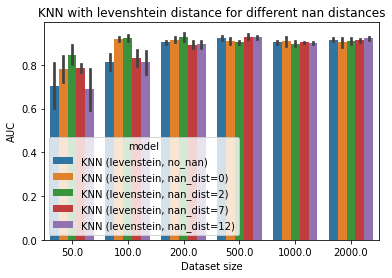

Baseline Random Forest (NaNs dropped in train) not found in scores, using KNN (levenstein, no_nan) instead


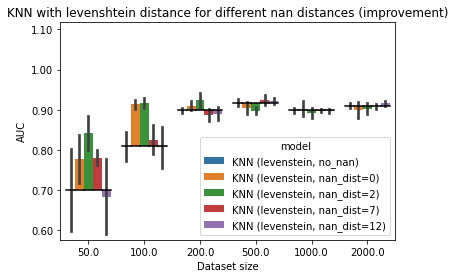

In [10]:
# levenstein distance (typically 0-14)

models_to_evaluate = [

    {'name': 'KNN (levenstein, no_nan)',
     'model': KNNString(metric=multi_lev, k=5),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': True},

    {'name': 'KNN (levenstein, nan_dist=0)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 0}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=2)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 2}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=7)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 7}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'KNN (levenstein, nan_dist=12)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 12}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},
]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000, 2000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "KNN with levenshtein distance for different nan distances"
output = "graphs/GILGFVFTL-knn-lev-nan-distances.png"
composed_df = compose_all(outputs, 'knn_lev')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

['ProximityForest (levenstein, no_nan)', 'ProximityForest (levenstein, nan_dist=7)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCD5AD430>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.7931034482758621
0.5325862068965517
0.7941379310344828
0.6424137931034481
0.7591379310344827

Evaluating model 2/2
{'name': 'ProximityForest (levenstein, nan_dist=7)', 'model': <util.knnstring.KNNString object at 0x0000028CCCD95970>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.8051724137931034
0.8043103448275861
0.7617241379310344
0.7620689655172413
0.7943103448275862
Baseline Random Forest (NaNs dropped in train) 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCD5AD430>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.8675862068965519
0.8232758620689654
0.8172413793103449
0.756896551724138
0.8027586206896552

Evaluating model 2/2
{'name': 'ProximityForest (levenstein, nan_dist=7)', 'model': <util.knnstring.KNNString object at 0x0000028CCCD95970>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.8703448275862069
0.8603448275862069
0.8289655172413792
0.7663793103448275
0.8227586206896552
Baseline Random Forest (NaNs dropped in train) 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCD5AD430>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9125862068965517
0.8977586206896552
0.9012068965517241
0.8956896551724137
0.9065517241379311

Evaluating model 2/2
{'name': 'ProximityForest (levenstein, nan_dist=7)', 'model': <util.knnstring.KNNString object at 0x0000028CCCD95970>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9034482758620689
0.9013793103448277
0.8993103448275862
0.8944827586206897
0.8620689655172413
Baseline Random Forest (NaNs dropped in train

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCD5AD430>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9127586206896552
0.9191379310344827
0.9241379310344826
0.9149999999999999
0.9391379310344826

Evaluating model 2/2
{'name': 'ProximityForest (levenstein, nan_dist=7)', 'model': <util.knnstring.KNNString object at 0x0000028CCCD95970>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9181034482758621
0.934655172413793
0.9218965517241379
0.9186206896551724
0.9510344827586207
Baseline Random Forest (NaNs dropped in train

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (levenstein, no_nan)', 'model': <util.knnstring.KNNString object at 0x0000028CCD5AD430>, 'group': 'knn', 'extract_features': False, 'drop_train_na': True}
0.9079310344827586
0.906896551724138
0.9010344827586206
0.9070689655172414
0.8913793103448275

Evaluating model 2/2
{'name': 'ProximityForest (levenstein, nan_dist=7)', 'model': <util.knnstring.KNNString object at 0x0000028CCCD95970>, 'group': 'knn', 'extract_features': False, 'drop_train_na': False}
0.9037931034482758
0.9093103448275862
0.8986206896551724
0.8999999999999999
0.9001724137931033
Baseline Random Forest (NaNs dropped in train

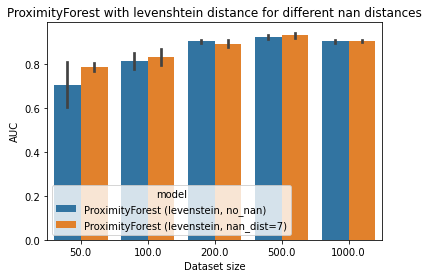

Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (levenstein, no_nan) instead


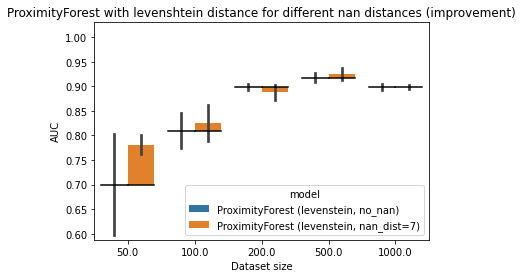

In [11]:
# proximity forest, levenstein distance

models_to_evaluate = [

    {'name': 'ProximityForest (levenstein, no_nan)',
     'model': KNNString(metric=multi_lev, k=5),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': True},

    {'name': 'ProximityForest (levenstein, nan_dist=7)',
     'model': KNNString(metric=multi_lev, k=5, metric_kwargs={'nan_distance': 7}),
     'group': 'knn',
     'extract_features': False,
     'drop_train_na': False},

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with levenshtein distance for different nan distances"
output = "graphs/GILGFVFTL-knn-lev-nan-distances.png"
composed_df = compose_all(outputs, 'knn_lev')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

['ProximityForest (sqrt, lev, nd=7)', 'ProximityForest (half, lev, nd=7)', 'ProximityForest (all, lev, nd=7)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/3
{'name': 'ProximityForest (sqrt, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E87C0>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


0.8722413793103448


Predicting: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


0.9068965517241379


Predicting: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


0.906551724137931


Predicting: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


0.9108620689655174


Predicting: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


0.8981034482758621

Evaluating model 2/3
{'name': 'ProximityForest (half, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8B50>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


0.8855172413793103


Predicting: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


0.8789655172413794


Predicting: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


0.9048275862068965


Predicting: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


0.8987931034482759


Predicting: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


0.9067241379310345

Evaluating model 3/3
{'name': 'ProximityForest (all, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8280>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


0.8893103448275862


Predicting: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


0.8939655172413793


Predicting: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


0.9048275862068966


Predicting: 100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


0.9024137931034484


Predicting: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


0.8979310344827586
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Finished evaluating 3 models at 20230615-090346 in 0:14:22.373898 seconds
['outputs/model-evaluations-20230615-084924-GILGFVFTL-50-imputation-constant-numbers/scores-20230615-090346.csv']
### Dataset size: 100 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/3
{'name': 'ProximityForest (sqrt, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E87C0>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


0.9298275862068965


Predicting: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


0.9232758620689655


Predicting: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


0.9179310344827587


Predicting: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


0.9158620689655171


Predicting: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


0.9275862068965517

Evaluating model 2/3
{'name': 'ProximityForest (half, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8B50>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


0.9344827586206896


Predicting: 100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


0.896551724137931


Predicting: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


0.9187931034482759


Predicting: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


0.9153448275862069


Predicting: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


0.9167241379310344

Evaluating model 3/3
{'name': 'ProximityForest (all, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8280>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


0.936551724137931


Predicting: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


0.8891379310344826


Predicting: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


0.9177586206896551


Predicting: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


0.9151724137931034


Predicting: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


0.9174137931034482
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Finished evaluating 3 models at 20230615-093547 in 0:31:57.100446 seconds
['outputs/model-evaluations-20230615-084924-GILGFVFTL-50-imputation-constant-numbers/scores-20230615-090346.csv', 'outputs/model-evaluations-20230615-090350-GILGFVFTL-100-imputation-constant-numbers/scores-20230615-093547.csv']
### Dataset size: 200 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/3
{'name': 'ProximityForest (sqrt, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E87C0>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


0.9308620689655172


Predicting: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


0.9167241379310345


Predicting: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


0.923103448275862


Predicting: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


0.9198275862068964


Predicting: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


0.92

Evaluating model 2/3
{'name': 'ProximityForest (half, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8B50>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


0.9146551724137931


Predicting: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


0.8965517241379309


Predicting: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


0.923448275862069


Predicting: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


0.921206896551724


Predicting: 100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


0.9179310344827587

Evaluating model 3/3
{'name': 'ProximityForest (all, lev, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCD6E8280>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


0.9191379310344827


Predicting: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


0.9127586206896551


Predicting: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


0.9329310344827587


Predicting: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


0.9265517241379311


Predicting: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


0.9287931034482759
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead
Finished evaluating 3 models at 20230615-111025 in 1:34:31.609738 seconds
['outputs/model-evaluations-20230615-084924-GILGFVFTL-50-imputation-constant-numbers/scores-20230615-090346.csv', 'outputs/model-evaluations-20230615-090350-GILGFVFTL-100-imputation-constant-numbers/scores-20230615-093547.csv', 'outputs/model-evaluations-20230615-093553-GILGFVFTL-200-imputation-constant-numbers/scores-20230615-111025.csv']


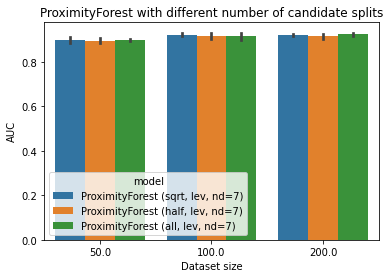

Baseline Random Forest (NaNs dropped in train) not found in scores, using ProximityForest (sqrt, lev, nd=7) instead


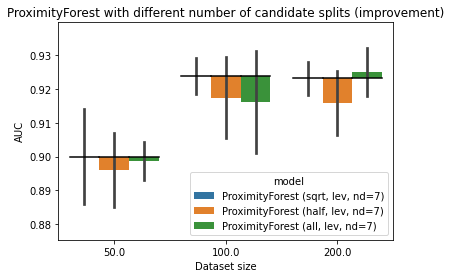

In [13]:
# proximity forest, different candidate_splits

models_to_evaluate = [

    {'name': 'ProximityForest (sqrt, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='sqrt',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (half, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='half',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (all, lev, nd=7)',
     'model': ProximityForestClassifier(distance_measure=multi_lev, sample_multiple_splits='all',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with different number of candidate splits"
output = "graphs/GILGFVFTL-pf-candidate-splits.png"
composed_df = compose_all(outputs, 'pf_candidate_splits')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

In [14]:
# proximity forest, different candidate_splits, tcrdist

# proximity forest, different candidate_splits

models_to_evaluate = [

    {'name': 'ProximityForest (sqrt, tcrdist, nd=7)',
     'model': ProximityForestClassifier(distance_measure=calculate_tcr_dist2_cached, sample_multiple_splits='sqrt',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (half, tcrdist, nd=7)',
     'model': ProximityForestClassifier(distance_measure=calculate_tcr_dist2_cached, sample_multiple_splits='half',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

    {'name': 'ProximityForest (all, tcrdist, nd=7)',
     'model': ProximityForestClassifier(distance_measure=calculate_tcr_dist2_cached, sample_multiple_splits='all',
                                        distance_kwargs={'nan_distance': 7}),
     'group': 'pf_candidate_splits',
     'extract_features': False,
     'drop_train_na': False},

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with different number of candidate splits"
output = "graphs/GILGFVFTL-pf-candidate-splits.png"
composed_df = compose_all(outputs, 'pf_candidate_splits')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

['ProximityForest (sqrt, tcrdist, nd=7)', 'ProximityForest (half, tcrdist, nd=7)', 'ProximityForest (all, tcrdist, nd=7)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/3
{'name': 'ProximityForest (sqrt, tcrdist, nd=7)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x0000028CCDEAFDC0>, 'group': 'pf_candidate_splits', 'extract_features': False, 'drop_train_na': False}


Fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Error: local variable 'df' referenced before assignment


UnboundLocalError: local variable 'df' referenced before assignment

['Random Forest (both chains, no_nan)', 'Random Forest (both chains, mean imputed)', 'Random Forest (Seperate chains, no_nan)', 'Random Forest (Seperate chains)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.8567241379310344
0.815862068965517
0.8737931034482759
0.8539655172413793
0.8617241379310344

Evaluating model 2/4
{'name': 'Random Forest (both chains, mean imputed)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.8825862068965518
0.8725862068965516
0.8877586206896552
0.8886206896551724
0.8879310344827587

Evaluating model 3/4
{'name': 'Random Forest (Seperate chains, no_nan)', 'model

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.9058620689655171
0.8698275862068966
0.8901724137931034
0.8629310344827587
0.8877586206896553

Evaluating model 2/4
{'name': 'Random Forest (both chains, mean imputed)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.9162068965517242
0.8962068965517241
0.9089655172413793
0.8896551724137931
0.8958620689655172

Evaluating model 3/4
{'name': 'Random Forest (Seperate chains, no_nan)', 'mod

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.9098275862068965
0.895
0.8920689655172414
0.8670689655172412
0.8844827586206897

Evaluating model 2/4
{'name': 'Random Forest (both chains, mean imputed)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.9131034482758621
0.9025862068965517
0.8944827586206897
0.891551724137931
0.8955172413793102

Evaluating model 3/4
{'name': 'Random Forest (Seperate chains, no_nan)', 'model': None, 'm

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.8832758620689654
0.8863793103448276
0.890344827586207
0.8832758620689655
0.8756896551724137

Evaluating model 2/4
{'name': 'Random Forest (both chains, mean imputed)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.8901724137931034
0.9074137931034483
0.9079310344827586
0.9005172413793102
0.8851724137931035

Evaluating model 3/4
{'name': 'Random Forest (Seperate chains, no_nan)', 'mo

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.891551724137931
0.8837931034482758
0.8979310344827586
0.8932758620689655
0.8758620689655172

Evaluating model 2/4
{'name': 'Random Forest (both chains, mean imputed)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.9168965517241381
0.9110344827586206
0.9163793103448276
0.8953448275862068
0.908103448275862

Evaluating model 3/4
{'name': 'Random Forest (Seperate chains, no_nan)', 'mod

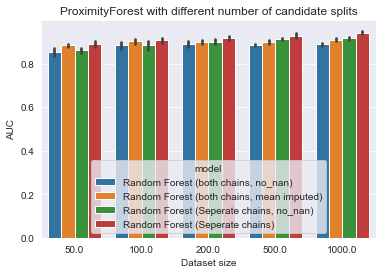

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (both chains, no_nan) instead


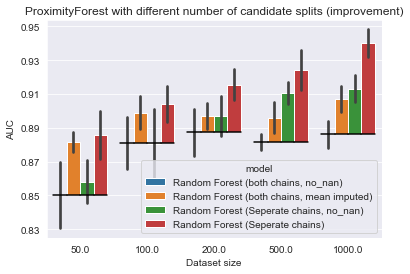

In [9]:
# seperate chains with or without nan

models_to_evaluate = [
    {
        'name': 'Random Forest (both chains, no_nan)',
        'model': RandomForestClassifier(random_state=0),
        'chain': 'both',
        'group': 'chain_inputs',
        'drop_train_na': True
    },

    {
        'name': 'Random Forest (both chains, mean imputed)',
        'model': RandomForestClassifier(random_state=0),
        'chain': 'both',
        'group': 'chain_inputs',
        'imputer': mean_imputer,
    },

    {
        'name': 'Random Forest (Seperate chains, no_nan)',
        'model': None,
        'model_alpha': RandomForestClassifier(random_state=0),
        'model_beta': RandomForestClassifier(random_state=0),
        'chain': 'seperate',
        'group': 'chain_inputs',
        'drop_train_na': True
    },

    {
        'name': 'Random Forest (Seperate chains)',
        'model_alpha': RandomForestClassifier(random_state=0),
        'model': None,
        'model_beta': RandomForestClassifier(random_state=0),
        'chain': 'seperate',
        'group': 'chain_inputs',
        'imputer': mean_imputer,
    },

]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "ProximityForest with different number of candidate splits"
output = "graphs/GILGFVFTL-pf-candidate-splits.png"
composed_df = compose_all(outputs, 'pf_candidate_splits')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

['Random Forest (0 imputed)', 'Random Forest (10 imputed)', 'Random Forest (100 imputed)', 'Random Forest (1000 imputed)']
### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.8649999999999998
0.8875862068965518
0.8701724137931035
0.8910344827586207
0.891551724137931

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.887758620689655
0.8741379310344827
0.8794827586206896
0.896551724137931
0.8863793103448276

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)', 'mo

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.9124137931034483
0.8893103448275862
0.9158620689655173
0.9072413793103448
0.9272413793103448

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.9024137931034483
0.8986206896551724
0.9167241379310345
0.888103448275862
0.9155172413793105

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)', 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.9182758620689655
0.8901724137931034
0.9374137931034481
0.8763793103448276
0.8977586206896551

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.9148275862068964
0.8736206896551724
0.906206896551724
0.9048275862068966
0.8746551724137932

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)',

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.91
0.9222413793103449
0.9246551724137931
0.9125862068965518
0.9125862068965516

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.8965517241379308
0.9058620689655172
0.9208620689655174
0.8996551724137931
0.9017241379310345

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)', 'model': Ra

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.9062068965517243
0.8993103448275863
0.9155172413793105
0.9103448275862068
0.9101724137931035

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.8956896551724138
0.8975862068965517
0.8994827586206896
0.8924137931034484
0.8893103448275861

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 1600, test: 108
No Nan: train: 432, test: 108

Evaluating model 1/4
{'name': 'Random Forest (0 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.898448275862069
0.9143103448275862
0.906551724137931
0.9070689655172414
0.903103448275862

Evaluating model 2/4
{'name': 'Random Forest (10 imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=10, strategy='constant'), 'group': 'rf_imputations'}
0.9031034482758621
0.9091379310344827
0.9141379310344828
0.9236206896551724
0.9056896551724138

Evaluating model 3/4
{'name': 'Random Forest (100 imputed)',

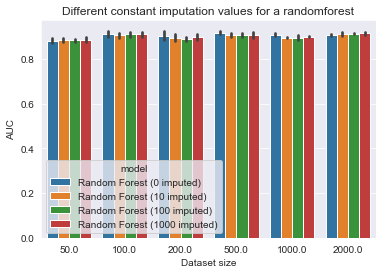

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (0 imputed) instead


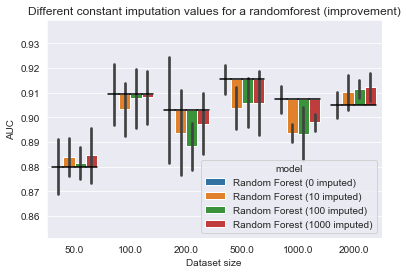

In [10]:
models_to_evaluate = [
    {
        'name': 'Random Forest (0 imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': zero_imputer,
        'group': 'rf_imputations'
    },

    {
        'name': 'Random Forest (10 imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=10),
        'group': 'rf_imputations'
    },

    {
        'name': 'Random Forest (100 imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=100),
        'group': 'rf_imputations'
    },

    {
        'name': 'Random Forest (1000 imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1000),
        'group': 'rf_imputations'
    }
]

print(list([m['name'] for m in models_to_evaluate]))
outputs = []

dataset_size = [50, 100, 200, 500, 1000, 2000]
for dataset_size in dataset_size:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)

title = "Different constant imputation values for a randomforest"
output = "graphs/GILGFVFTL-rf-c-imputations-0-10-100-1000.png"
composed_df = compose_all(outputs, 'pf_candidate_splits')
plot_scores(composed_df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC",
            output_file=output,
            plot=True)

### Epitope: GILGFVFTL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 1200, test: 76
No Nan: train: 321, test: 76

Evaluating model 1/4
{'name': 'Random Forest (Seperate chains)', 'model_alpha': RandomForestClassifier(random_state=0), 'model': None, 'model_beta': RandomForestClassifier(random_state=0), 'chain': 'seperate', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.9009866102889359
0.8984480431848854
0.8944980147475894
0.9361344537815126
0.9149425287356322

Evaluating model 2/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.8872445384073291
0.9190283400809716
0.8794668179239933
0.9365546218487395
0.9340996168582376

Evaluat

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47471 to 46335 (because of overlap with positive samples)
Positive samples: alpha only: 2158, beta only: 4667, both: 567, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4935, beta only: 15899, both: 25501, none: 0
Nan: train: 1200, test: 27
No Nan: train: 87, test: 27

Evaluating model 1/4
{'name': 'Random Forest (Seperate chains)', 'model_alpha': RandomForestClassifier(random_state=0), 'model': None, 'model_beta': RandomForestClassifier(random_state=0), 'chain': 'seperate', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.5294117647058824
0.7666666666666666
0.6479289940828402
0.6333333333333333
0.47928994082840237

Evaluating model 2/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.6411764705882352
0.7375
0.636094674556213
0.37222222222222223
0.5473372781065089

Evaluating model 3/4

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54349 to 54195 (because of overlap with positive samples)
Positive samples: alpha only: 95, beta only: 349, both: 70, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7039, beta only: 20304, both: 26852, none: 0
Nan: train: 822, test: 27
No Nan: train: 102, test: 27

Evaluating model 1/4
{'name': 'Random Forest (Seperate chains)', 'model_alpha': RandomForestClassifier(random_state=0), 'model': None, 'model_beta': RandomForestClassifier(random_state=0), 'chain': 'seperate', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.7006172839506173
0.6775147928994083
0.7058823529411765
0.5177777777777778
0.7303030303030303

Evaluating model 2/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.6358024691358024
0.6153846153846154
0.5909090909090909
0.6888888888888889
0.6424242424242425

Evaluating mo

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54429 to 54301 (because of overlap with positive samples)
Positive samples: alpha only: 8, beta only: 181, both: 245, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7146, beta only: 20484, both: 26671, none: 0
Nan: train: 694, test: 105
No Nan: train: 364, test: 105

Evaluating model 1/4
{'name': 'Random Forest (Seperate chains)', 'model_alpha': RandomForestClassifier(random_state=0), 'model': None, 'model_beta': RandomForestClassifier(random_state=0), 'chain': 'seperate', 'group': 'chain_inputs', 'imputer': SimpleImputer()}
0.9424231057764441
0.9276442307692309
0.8654336734693877
0.9364583333333333
0.8698899371069182

Evaluating model 2/4
{'name': 'Random Forest (both chains, no_nan)', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs', 'drop_train_na': True}
0.8990997749437359
0.8653846153846154
0.8403486394557823
0.9233333333333333
0.8592767295597484

Evaluating 

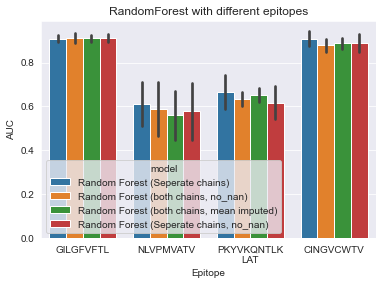

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (Seperate chains) instead


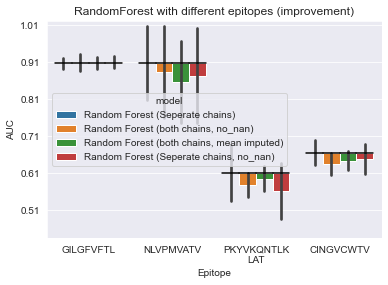

In [25]:
epitopes = [
    'GILGFVFTL',  # 1/3 van alles
    'NLVPMVATV',  # 2/5 alpha, 1/10 beta, 6/10 both
    # 'LLLGIGILV', # 2/3 alpha, 1/3 beta, 0 both -> 0 both dus droppen gaat ni
    'PKYVKQNTLKLAT',  # 3/5 beta, 1/10 alfa, 1/10 both
    'CINGVCWTV'  # 3/5 beta, 2/5both (en heel klein beetje alpha)
]

models_to_evaluate = [
    {
        'name': 'Random Forest (Seperate chains)',
        'model_alpha': RandomForestClassifier(random_state=0),
        'model': None,
        'model_beta': RandomForestClassifier(random_state=0),
        'chain': 'seperate',
        'group': 'chain_inputs',
        'imputer': mean_imputer,
    },
    {
        'name': 'Random Forest (both chains, no_nan)',
        'model': RandomForestClassifier(random_state=0),
        'chain': 'both',
        'group': 'chain_inputs',
        'drop_train_na': True
    },

    {
        'name': 'Random Forest (both chains, mean imputed)',
        'model': RandomForestClassifier(random_state=0),
        'chain': 'both',
        'group': 'chain_inputs',
        'imputer': mean_imputer,
    },

    {
        'name': 'Random Forest (Seperate chains, no_nan)',
        'model': None,
        'model_alpha': RandomForestClassifier(random_state=0),
        'model_beta': RandomForestClassifier(random_state=0),
        'chain': 'seperate',
        'group': 'chain_inputs',
        'drop_train_na': True
    },

]

outputs = []
for epitope in epitopes:
    print(f"### Epitope: {epitope} ###")
    update_data_per_fold(None, epitope_=epitope, fixed_test_size=False, max_samples=1500)
    scores, output_csv = evaluate_model_list(models_to_evaluate)
    outputs.append(output_csv)
    print(outputs)
    print(f"Finished {epitope}")
    print(outputs)

title = "RandomForest with different epitopes"
output = "graphs/GILGFVFTL-rf-different-epitopes.png"
composed_df = compose_all(outputs, 'rf_different_epitopes')
plot_scores(composed_df, title, wrap=True, x="epitope", hue="model", xlabel="Epitope", ylabel="AUC",
            output_file=output,
            plot=True)


In [38]:
from util import get_vdjdb

vdjdb = get_vdjdb()
# epitopes with more than 100 samples, with at least 5 samples not containing nans
epitopes = vdjdb.groupby('epitope').filter(lambda x: len(x) > 100 and len(x.dropna()) > 20).epitope.unique()
print(f"Found {len(epitopes)} epitopes")
epitopes

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Found 27 epitopes


array(['NLVPMVATV', 'TPRVTGGGAM', 'ELAGIGILTV', 'YSEHPTFTSQY',
       'PKYVKQNTLKLAT', 'GILGFVFTL', 'GLCTLVAML', 'SSLENFRAYV',
       'ASNENMETM', 'YLQPRTFLL', 'LLWNGPMAV', 'CINGVCWTV', 'RAKFKQLL',
       'AVFDRKSDAK', 'IVTDFSVIK', 'SSPPMFRV', 'KSKRTPMGF', 'ATDALMTGF',
       'KLGGALQAK', 'RLRAEAQVK', 'HGIRNASFI', 'LSLRNPILV', 'SSYRRPVGI',
       'DATYQRTRALVR', 'LTDEMIAQY', 'TTDPSFLGRY', 'SPRWYFYYL'],
      dtype=object)

In [39]:

# epitopes = [
#     'GILGFVFTL', # 1/3 van alles
#     'NLVPMVATV',  # 2/5 alpha, 1/10 beta, 6/10 both
#     # 'LLLGIGILV', # 2/3 alpha, 1/3 beta, 0 both -> 0 both dus droppen gaat ni
#     'PKYVKQNTLKLAT', # 3/5 beta, 1/10 alfa, 1/10 both
#     'CINGVCWTV' # 3/5 beta, 2/5both (en heel klein beetje alpha)
# ]

results = []


def train_diff_epitope(df, epitope, drop_train_nan, seperate_chains, seed):
    print(f"Evaluating {epitope}, drop_train_nan={drop_train_nan}, seperate_chains={seperate_chains}, seed={seed}")

    ## Creating the dataframe
    if len(df) > 1500:
        df_new = df.sample(1500, random_state=seed)
    else:
        df_new = df

    df_train, df_test = train_test_split(df_new, test_size=0.2, random_state=seed)

    test = df_test.dropna()

    if drop_train_nan:
        df_train = df_train.dropna()

    # with nan in train set
    x = get_features(df_train)
    y = df_train['reaction']

    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)

    y_test = test['reaction']

    alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(df_train)

    mean_imputer = impute.SimpleImputer(strategy='mean')

    ## Training the model
    if seperate_chains:
        model_alpha = RandomForestClassifier()
        model_beta = RandomForestClassifier()

        auc = evaluate_seperate_chains(model_alpha, model_beta, x, y, x_test, y_test, imputer=mean_imputer)
    else:
        model = RandomForestClassifier()
        model = Pipeline([('imputer', mean_imputer), ('model', model)])
        model_imputer = None
        auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)

    print(auc)

    # Log the results
    model_name = "Random Forest ("
    if seperate_chains:
        model_name += "Seperate chains, "
    else:
        model_name += "Both chains, "
    if drop_train_nan:
        model_name += "no nan in train)"
    else:
        model_name += "nan in train)"

    total_count = alpha_only_count_pos + beta_only_count_pos + both_count_pos + non_count_pos
    a_frac, b_frac, both_frac, non_frac = alpha_only_count_pos / total_count, beta_only_count_pos / total_count, both_count_pos / total_count, non_count_pos / total_count

    results.append({
        'epitope': epitope,
        'drop_train_nan': drop_train_nan,
        'serperate_chains': seperate_chains,
        'seed': seed,
        'auc': auc,
        'alpha_only_count_pos': alpha_only_count_pos,
        'beta_only_count_pos': beta_only_count_pos,
        'both_count_pos': both_count_pos,
        'non_count_pos': non_count_pos,
        'model': model_name,
        'a_frac': a_frac,
        'b_frac': b_frac,
        'both_frac': both_frac,
        'non_frac': non_frac
    })


folds = 5
for epitope in epitopes:
    print(f"### Epitope: {epitope} ###")

    try:
        df = get_epitope_df(epitope, species=species)

        for seed in range(folds):
            train_diff_epitope(df, epitope, drop_train_nan=True, seperate_chains=False, seed=seed)
            train_diff_epitope(df, epitope, drop_train_nan=False, seperate_chains=False, seed=seed)
            train_diff_epitope(df, epitope, drop_train_nan=True, seperate_chains=True, seed=seed)
            train_diff_epitope(df, epitope, drop_train_nan=False, seperate_chains=True, seed=seed)
    except Exception as e:
        print(f"Epitope {epitope} throwed an error: {e}")

### Epitope: NLVPMVATV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47471 to 46335 (because of overlap with positive samples)
Positive samples: alpha only: 2158, beta only: 4667, both: 567, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4935, beta only: 15899, both: 25501, none: 0
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=0
0.611764705882353
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=0
0.5647058823529412
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=True, seed=0
0.6676470588235295
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=True, seed=0
0.5735294117647058
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=1
0.6166666666666667
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=1
0.625
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=True, seed=1
0.6
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=True, seed=1
0.6041666666666

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54494 to 54396 (because of overlap with positive samples)
Positive samples: alpha only: 4, beta only: 302, both: 63, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7168, beta only: 20337, both: 26891, none: 0
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=0
0.8290598290598291
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=0
0.9401709401709402
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=True, seed=0
0.9145299145299145
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=True, seed=0
0.9829059829059829
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=1
0.8484848484848485
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=1
0.9848484848484849
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=True, seed=1
0.890909090909091
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chai

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 52579 to 51537 (because of overlap with positive samples)
Positive samples: alpha only: 2, beta only: 1879, both: 403, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7083, beta only: 18668, both: 25786, none: 0
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=0
0.8085553997194951
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=False, seed=0
0.8127629733520336
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=True, seed=0
0.8267882187938289
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=True, seed=0
0.8401122019635344
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=1
0.9157754010695187
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=False, seed=1
0.9425133689839573
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=True, seed=1
0.9385026737967914
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_c

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54730 to 54714 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 111, both: 22, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7166, beta only: 20559, both: 26989, none: 0
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=False, seed=0
0.84375
Evaluating YSEHPTFTSQY, drop_train_nan=False, seperate_chains=False, seed=0
1.0
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=True, seed=0
0.90625
Evaluating YSEHPTFTSQY, drop_train_nan=False, seperate_chains=True, seed=0
0.96875
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=False, seed=1
0.6
Evaluating YSEHPTFTSQY, drop_train_nan=False, seperate_chains=False, seed=1
0.78
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=True, seed=1
0.64
Evaluating YSEHPTFTSQY, drop_train_nan=False, seperate_chains=True, seed=1
0.64
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54349 to 54195 (because of overlap with positive samples)
Positive samples: alpha only: 95, beta only: 349, both: 70, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7039, beta only: 20304, both: 26852, none: 0
Evaluating PKYVKQNTLKLAT, drop_train_nan=True, seperate_chains=False, seed=0
0.6141975308641976
Evaluating PKYVKQNTLKLAT, drop_train_nan=False, seperate_chains=False, seed=0
0.7253086419753088
Evaluating PKYVKQNTLKLAT, drop_train_nan=True, seperate_chains=True, seed=0
0.654320987654321
Evaluating PKYVKQNTLKLAT, drop_train_nan=False, seperate_chains=True, seed=0
0.7037037037037037
Evaluating PKYVKQNTLKLAT, drop_train_nan=True, seperate_chains=False, seed=1
0.5946745562130178
Evaluating PKYVKQNTLKLAT, drop_train_nan=False, seperate_chains=False, seed=1
0.5857988165680473
Evaluating PKYVKQNTLKLAT, drop_train_nan=True, seperate_chains=True, seed=1
0.742603550295858
Evaluating PKYVKQNTLKLAT, drop_train_

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Evaluating GILGFVFTL, drop_train_nan=True, seperate_chains=False, seed=0
0.9023960535588442
Evaluating GILGFVFTL, drop_train_nan=False, seperate_chains=False, seed=0
0.8960535588442566
Evaluating GILGFVFTL, drop_train_nan=True, seperate_chains=True, seed=0
0.9045102184637068
Evaluating GILGFVFTL, drop_train_nan=False, seperate_chains=True, seed=0
0.8928823114869627
Evaluating GILGFVFTL, drop_train_nan=True, seperate_chains=False, seed=1
0.9034598214285715
Evaluating GILGFVFTL, drop_train_nan=False, seperate_chains=False, seed=1
0.8911830357142857
Evaluating GILGFVFTL, drop_train_nan=True, seperate_chains=True, seed=1
0.9213169642857145
Evaluating GILGFVFTL, drop_train_nan=False, seperate_chain

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53400 to 51774 (because of overlap with positive samples)
Positive samples: alpha only: 42, beta only: 1040, both: 381, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7109, beta only: 19444, both: 25221, none: 0
Evaluating GLCTLVAML, drop_train_nan=True, seperate_chains=False, seed=0
0.9182209469153515
Evaluating GLCTLVAML, drop_train_nan=False, seperate_chains=False, seed=0
0.8891678622668578
Evaluating GLCTLVAML, drop_train_nan=True, seperate_chains=True, seed=0
0.9512195121951219
Evaluating GLCTLVAML, drop_train_nan=False, seperate_chains=True, seed=0
0.9418938307030129
Evaluating GLCTLVAML, drop_train_nan=True, seperate_chains=False, seed=1
0.890926640926641
Evaluating GLCTLVAML, drop_train_nan=False, seperate_chains=False, seed=1
0.9475546975546976
Evaluating GLCTLVAML, drop_train_nan=True, seperate_chains=True, seed=1
0.9099099099099098
Evaluating GLCTLVAML, drop_train_nan=False, seperate_chains=Tr

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSLENFRAYV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: ASNENMETM ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope ASNENMETM throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: YLQPRTFLL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53537 to 53182 (because of overlap with positive samples)
Positive samples: alpha only: 418, beta only: 551, both: 357, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6727, beta only: 20102, both: 26353, none: 0
Evaluating YLQPRTFLL, drop_train_nan=True, seperate_chains=False, seed=0
0.8742498636115659
Evaluating YLQPRTFLL, drop_train_nan=False, seperate_chains=False, seed=0
0.8617021276595744
Evaluating YLQPRTFLL, drop_train_nan=True, seperate_chains=True, seed=0
0.8420621931260229
Evaluating YLQPRTFLL, drop_train_nan=False, seperate_chains=True, seed=0
0.8671576650300055
Evaluating YLQPRTFLL, drop_train_nan=True, seperate_chains=False, seed=1
0.8435975609756098
Evaluating YLQPRTFLL, drop_train_nan=False, seperate_chains=False, seed=1
0.8378048780487805
Evaluating YLQPRTFLL, drop_train_nan=True, seperate_chains=True, seed=1
0.8679878048780488
Evaluating YLQPRTFLL, drop_train_nan=False, seperate_chains=T

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54321 to 54039 (because of overlap with positive samples)
Positive samples: alpha only: 86, beta only: 209, both: 247, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7051, beta only: 20439, both: 26549, none: 0
Evaluating LLWNGPMAV, drop_train_nan=True, seperate_chains=False, seed=0
0.8412393162393162
Evaluating LLWNGPMAV, drop_train_nan=False, seperate_chains=False, seed=0
0.861965811965812
Evaluating LLWNGPMAV, drop_train_nan=True, seperate_chains=True, seed=0
0.8777777777777779
Evaluating LLWNGPMAV, drop_train_nan=False, seperate_chains=True, seed=0
0.8767094017094017
Evaluating LLWNGPMAV, drop_train_nan=True, seperate_chains=False, seed=1
0.8616352201257861
Evaluating LLWNGPMAV, drop_train_nan=False, seperate_chains=False, seed=1
0.8492812219227313
Evaluating LLWNGPMAV, drop_train_nan=True, seperate_chains=True, seed=1
0.8769092542677448
Evaluating LLWNGPMAV, drop_train_nan=False, seperate_chains=Tru

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54429 to 54301 (because of overlap with positive samples)
Positive samples: alpha only: 8, beta only: 181, both: 245, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7146, beta only: 20484, both: 26671, none: 0
Evaluating CINGVCWTV, drop_train_nan=True, seperate_chains=False, seed=0
0.9056639159789948
Evaluating CINGVCWTV, drop_train_nan=False, seperate_chains=False, seed=0
0.9009752438109528
Evaluating CINGVCWTV, drop_train_nan=True, seperate_chains=True, seed=0
0.9407351837959491
Evaluating CINGVCWTV, drop_train_nan=False, seperate_chains=True, seed=0
0.9367966991747937
Evaluating CINGVCWTV, drop_train_nan=True, seperate_chains=False, seed=1
0.8747596153846154
Evaluating CINGVCWTV, drop_train_nan=False, seperate_chains=False, seed=1
0.8932692307692308
Evaluating CINGVCWTV, drop_train_nan=True, seperate_chains=True, seed=1
0.8786057692307692
Evaluating CINGVCWTV, drop_train_nan=False, seperate_chains=Tru

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53365 to 50800 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 263, both: 1235, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7076, beta only: 20288, both: 23436, none: 0
Evaluating RAKFKQLL, drop_train_nan=True, seperate_chains=False, seed=0
0.854091956967213
Evaluating RAKFKQLL, drop_train_nan=False, seperate_chains=False, seed=0
0.8535796618852459
Evaluating RAKFKQLL, drop_train_nan=True, seperate_chains=True, seed=0
0.888671875
Evaluating RAKFKQLL, drop_train_nan=False, seperate_chains=True, seed=0
0.8799948770491802
Evaluating RAKFKQLL, drop_train_nan=True, seperate_chains=False, seed=1
0.8919667590027701
Evaluating RAKFKQLL, drop_train_nan=False, seperate_chains=False, seed=1
0.8863606384382009
Evaluating RAKFKQLL, drop_train_nan=True, seperate_chains=True, seed=1
0.9256364595699775
Evaluating RAKFKQLL, drop_train_nan=False, seperate_chains=True, seed=1
0.918

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53081 to 48044 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 18, both: 1764, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7053, beta only: 20523, both: 20468, none: 0
Evaluating AVFDRKSDAK, drop_train_nan=True, seperate_chains=False, seed=0
0.5511220162942494
Evaluating AVFDRKSDAK, drop_train_nan=False, seperate_chains=False, seed=0
0.5828052789556434
Evaluating AVFDRKSDAK, drop_train_nan=True, seperate_chains=True, seed=0
0.5762304064033541
Evaluating AVFDRKSDAK, drop_train_nan=False, seperate_chains=True, seed=0
0.6110105293248845
Evaluating AVFDRKSDAK, drop_train_nan=True, seperate_chains=False, seed=1
0.5886944181646169
Evaluating AVFDRKSDAK, drop_train_nan=False, seperate_chains=False, seed=1
0.5668401135288553
Evaluating AVFDRKSDAK, drop_train_nan=True, seperate_chains=True, seed=1
0.5661305581835383
Evaluating AVFDRKSDAK, drop_train_nan=False, seperate_ch

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54106 to 50393 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 28, both: 729, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7100, beta only: 20558, both: 22735, none: 0
Evaluating IVTDFSVIK, drop_train_nan=True, seperate_chains=False, seed=0
0.73222109016811
Evaluating IVTDFSVIK, drop_train_nan=False, seperate_chains=False, seed=0
0.7400407539480387
Evaluating IVTDFSVIK, drop_train_nan=True, seperate_chains=True, seed=0
0.7685685175751401
Evaluating IVTDFSVIK, drop_train_nan=False, seperate_chains=True, seed=0
0.7529801324503311
Evaluating IVTDFSVIK, drop_train_nan=True, seperate_chains=False, seed=1
0.7612545018007203
Evaluating IVTDFSVIK, drop_train_nan=False, seperate_chains=False, seed=1
0.7487745098039217
Evaluating IVTDFSVIK, drop_train_nan=True, seperate_chains=True, seed=1
0.7940926370548219
Evaluating IVTDFSVIK, drop_train_nan=False, seperate_chains=True, 

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSPPMFRV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: KSKRTPMGF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54689 to 54650 (because of overlap with positive samples)
Positive samples: alpha only: 4, beta only: 44, both: 126, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7168, beta only: 20620, both: 26862, none: 0
Evaluating KSKRTPMGF, drop_train_nan=True, seperate_chains=False, seed=0
0.9201183431952663
Evaluating KSKRTPMGF, drop_train_nan=False, seperate_chains=False, seed=0
0.9068047337278107
Evaluating KSKRTPMGF, drop_train_nan=True, seperate_chains=True, seed=0
0.9215976331360947
Evaluating KSKRTPMGF, drop_train_nan=False, seperate_chains=True, seed=0
0.9460059171597633
Evaluating KSKRTPMGF, drop_train_nan=True, seperate_chains=False, seed=1
0.8483245149911818
Evaluating KSKRTPMGF, drop_train_nan=False, seperate_chains=False, seed=1
0.9047619047619048
Evaluating KSKRTPMGF, drop_train_nan=True, seperate_chains=True, seed=1
0.8765432098765432
Evaluating KSKRTPMGF, drop_train_nan=False, seperate_chains=True

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54686 to 54649 (because of overlap with positive samples)
Positive samples: alpha only: 13, beta only: 31, both: 133, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7156, beta only: 20630, both: 26863, none: 0
Evaluating ATDALMTGF, drop_train_nan=True, seperate_chains=False, seed=0
0.8365217391304347
Evaluating ATDALMTGF, drop_train_nan=False, seperate_chains=False, seed=0
0.8695652173913043
Evaluating ATDALMTGF, drop_train_nan=True, seperate_chains=True, seed=0
0.9
Evaluating ATDALMTGF, drop_train_nan=False, seperate_chains=True, seed=0
0.951304347826087
Evaluating ATDALMTGF, drop_train_nan=True, seperate_chains=False, seed=1
0.8105263157894737
Evaluating ATDALMTGF, drop_train_nan=False, seperate_chains=False, seed=1
0.8236842105263158
Evaluating ATDALMTGF, drop_train_nan=True, seperate_chains=True, seed=1
0.8649122807017543
Evaluating ATDALMTGF, drop_train_nan=False, seperate_chains=True, seed=1
0.8780

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 40889 to 35633 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 13974, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6557, beta only: 20386, both: 8690, none: 0
Evaluating KLGGALQAK, drop_train_nan=True, seperate_chains=False, seed=0
Epitope KLGGALQAK throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: RLRAEAQVK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54432 to 52058 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 431, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7145, beta only: 20661, both: 24252, none: 0
Evaluating RLRAEAQVK, drop_train_nan=True, seperate_chains=False, seed=0
0.590870786516854
Evaluating RLRAEAQVK, drop_train_nan=False, seperate_chains=False, seed=0
0.532935393258427
Evaluating RLRAEAQVK, drop_train_nan=True, seperate_chains=True, seed=0
0.5770365168539326
Evaluating RLRAEAQVK, drop_train_nan=False, seperate_chains=True, seed=0
0.5857443820224719
Evaluating RLRAEAQVK, drop_train_nan=True, seperate_chains=False, seed=1
0.6177777777777778
Evaluating RLRAEAQVK, drop_train_nan=False, seperate_chains=False, seed=1
0.6237275985663082
Evaluating RLRAEAQVK, drop_train_nan=True, seperate_chains=True, seed=1
0.6162007168458782
Evaluating RLRAEAQVK, drop_train_nan=False, seperate_chains=True, s

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope HGIRNASFI throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: LSLRNPILV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope LSLRNPILV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: SSYRRPVGI ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSYRRPVGI throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: DATYQRTRALVR ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54721 to 54654 (because of overlap with positive samples)
Positive samples: alpha only: 13, beta only: 20, both: 109, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7155, beta only: 20650, both: 26849, none: 0
Evaluating DATYQRTRALVR, drop_train_nan=True, seperate_chains=False, seed=0
0.7825484764542936
Evaluating DATYQRTRALVR, drop_train_nan=False, seperate_chains=False, seed=0
0.8047091412742382
Evaluating DATYQRTRALVR, drop_train_nan=True, seperate_chains=True, seed=0
0.8060941828254848
Evaluating DATYQRTRALVR, drop_train_nan=False, seperate_chains=True, seed=0
0.8296398891966759
Evaluating DATYQRTRALVR, drop_train_nan=True, seperate_chains=False, seed=1
0.8
Evaluating DATYQRTRALVR, drop_train_nan=False, seperate_chains=False, seed=1
0.8105263157894737
Evaluating DATYQRTRALVR, drop_train_nan=True, seperate_chains=True, seed=1
0.8157894736842105
Evaluating DATYQRTRALVR, drop_train_nan=False, seperate_c

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54728 to 54674 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 135, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7164, beta only: 20670, both: 26840, none: 0
Evaluating LTDEMIAQY, drop_train_nan=True, seperate_chains=False, seed=0
0.7592592592592592
Evaluating LTDEMIAQY, drop_train_nan=False, seperate_chains=False, seed=0
0.7492283950617283
Evaluating LTDEMIAQY, drop_train_nan=True, seperate_chains=True, seed=0
0.7577160493827161
Evaluating LTDEMIAQY, drop_train_nan=False, seperate_chains=True, seed=0
0.7631172839506173
Evaluating LTDEMIAQY, drop_train_nan=True, seperate_chains=False, seed=1
0.6564516129032257
Evaluating LTDEMIAQY, drop_train_nan=False, seperate_chains=False, seed=1
0.5693548387096774
Evaluating LTDEMIAQY, drop_train_nan=True, seperate_chains=True, seed=1
0.7040322580645162
Evaluating LTDEMIAQY, drop_train_nan=False, seperate_chains=True,

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54609 to 54423 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 254, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7137, beta only: 20647, both: 26639, none: 0
Evaluating TTDPSFLGRY, drop_train_nan=True, seperate_chains=False, seed=0
0.6031583264971287
Evaluating TTDPSFLGRY, drop_train_nan=False, seperate_chains=False, seed=0
0.6066447908121411
Evaluating TTDPSFLGRY, drop_train_nan=True, seperate_chains=True, seed=0
0.663453650533224
Evaluating TTDPSFLGRY, drop_train_nan=False, seperate_chains=True, seed=0
0.6882690730106644
Evaluating TTDPSFLGRY, drop_train_nan=True, seperate_chains=False, seed=1
0.7436170212765957
Evaluating TTDPSFLGRY, drop_train_nan=False, seperate_chains=False, seed=1
0.6627659574468084
Evaluating TTDPSFLGRY, drop_train_nan=True, seperate_chains=True, seed=1
0.6902127659574468
Evaluating TTDPSFLGRY, drop_train_nan=False, seperate_chain

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54554 to 54498 (because of overlap with positive samples)
Positive samples: alpha only: 18, beta only: 97, both: 194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7152, beta only: 20566, both: 26780, none: 0
Evaluating SPRWYFYYL, drop_train_nan=True, seperate_chains=False, seed=0
0.8524305555555556
Evaluating SPRWYFYYL, drop_train_nan=False, seperate_chains=False, seed=0
0.8098958333333333
Evaluating SPRWYFYYL, drop_train_nan=True, seperate_chains=True, seed=0
0.8984375
Evaluating SPRWYFYYL, drop_train_nan=False, seperate_chains=True, seed=0
0.8650173611111112
Evaluating SPRWYFYYL, drop_train_nan=True, seperate_chains=False, seed=1
0.7693877551020408
Evaluating SPRWYFYYL, drop_train_nan=False, seperate_chains=False, seed=1
0.7731292517006803
Evaluating SPRWYFYYL, drop_train_nan=True, seperate_chains=True, seed=1
0.7877551020408163
Evaluating SPRWYFYYL, drop_train_nan=False, seperate_chains=True, seed=1

In [40]:
import time

# create a dataframe from the results
df = pd.DataFrame(results)
timestr = time.strftime("%Y%m%d-%H%M%S")
df.to_csv(f"outputs/rf_different_epitopes_{timestr}.csv")
print(f"Saved to outputs/rf_different_epitopes_{timestr}.csv")

Saved to outputs/rf_different_epitopes_20230616-133238.csv


In [30]:
# load the dataframe
df = pd.read_csv("outputs/rf_different_epitopes_20230616-133238.csv")

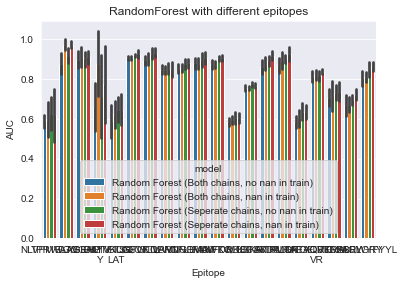

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (Both chains, no nan in train) instead


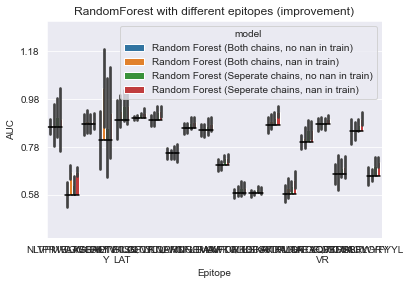

In [31]:
# plot the results
title = "RandomForest with different epitopes"
output = "graphs/rf-different-epitopes.png"
plot_scores(df, title, wrap=True, x="epitope", hue="model", xlabel="Epitope", ylabel="AUC",
            output_file=output,
            plot=True)

In [32]:
df.head()

,Unnamed: 0,epitope,drop_train_nan,serperate_chains,seed,auc,alpha_only_count_pos,beta_only_count_pos,both_count_pos,non_count_pos,model,a_frac,b_frac,both_frac,non_frac,improvement_hue
0,0,NLVPMVATV,True,False,0,0.611765,0,0,87,0,"Random Forest (Both chains, no nan in train)",0.000000,0.000000,1.000,0.0,0.025114
1,1,NLVPMVATV,False,False,0,0.564706,364,746,90,0,"Random Forest (Both chains, nan in train)",0.303333,0.621667,0.075,0.0,-0.021945
2,2,NLVPMVATV,True,True,0,0.667647,0,0,87,0,"Random Forest (Seperate chains, no nan in train)",0.000000,0.000000,1.000,0.0,0.080996
3,3,NLVPMVATV,False,True,0,0.573529,364,746,90,0,"Random Forest (Seperate chains, nan in train)",0.303333,0.621667,0.075,0.0,-0.013121
4,4,NLVPMVATV,True,False,1,0.616667,0,0,85,0,"Random Forest (Both chains, no nan in train)",0.000000,0.000000,1.000,0.0,0.030016


In [33]:
# only look at serperate_chains=False
df_rf = df[df.serperate_chains == False].copy()
# Create a table with the means
df_rf_means = df_rf.groupby(['epitope', 'drop_train_nan']).mean().reset_index()

In [34]:
# create a dataframe containing the improvements in auc (which is the drop_train_nan=False - drop_train_nan=True)
df_rf_improvements = df_rf_means[df_rf_means.drop_train_nan == False].copy()
df_rf_improvements['auc_improvement'] = df_rf_improvements['auc'] - df_rf_means[df_rf_means.drop_train_nan == True][
    'auc'].values
df_rf_improvements

,epitope,drop_train_nan,Unnamed: 0,serperate_chains,seed,auc,alpha_only_count_pos,beta_only_count_pos,both_count_pos,non_count_pos,a_frac,b_frac,both_frac,non_frac,improvement_hue,auc_improvement
0,ATDALMTGF,False,289.0,0.0,2.0,0.891383,20.2,47.4,215.4,0.0,0.071378,0.167491,0.761131,0.0,0.024499,0.024499
2,AVFDRKSDAK,False,229.0,0.0,2.0,0.592545,0.0,10.4,1189.6,0.0,0.000000,0.008667,0.991333,0.0,0.010276,0.010276
4,CINGVCWTV,False,189.0,0.0,2.0,0.876180,12.8,294.0,387.2,0.0,0.018444,0.423631,0.557925,0.0,-0.001272,-0.001272
6,DATYQRTRALVR,False,329.0,0.0,2.0,0.817098,20.6,33.2,173.2,0.0,0.090749,0.146256,0.762996,0.0,0.005637,0.005637
8,ELAGIGILTV,False,49.0,0.0,2.0,0.908286,0.6,1003.6,195.8,0.0,0.000500,0.836333,0.163167,0.0,0.012382,0.012382
10,GILGFVFTL,False,109.0,0.0,2.0,0.904467,410.2,456.2,333.6,0.0,0.341833,0.380167,0.278000,0.0,0.000799,0.000799
12,GLCTLVAML,False,129.0,0.0,2.0,0.899980,36.4,857.4,306.2,0.0,0.030333,0.714500,0.255167,0.0,0.006939,0.006939
14,IVTDFSVIK,False,249.0,0.0,2.0,0.755909,0.0,43.0,1157.0,0.0,0.000000,0.035833,0.964167,0.0,0.001693,0.001693
16,KSKRTPMGF,False,269.0,0.0,2.0,0.876239,6.4,70.0,201.6,0.0,0.023022,0.251799,0.725180,0.0,0.016912,0.016912
18,LLWNGPMAV,False,169.0,0.0,2.0,0.853903,136.6,336.4,394.0,0.0,0.157555,0.388005,0.454441,0.0,0.002211,0.002211


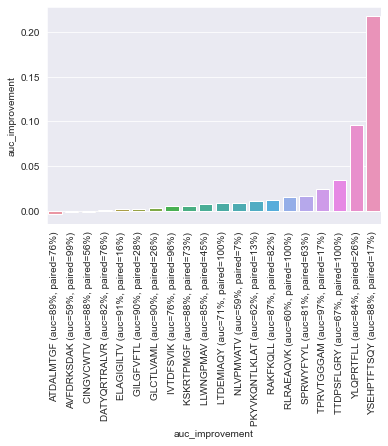

<Figure size 432x288 with 0 Axes>

In [35]:
from matplotlib.ticker import PercentFormatter
# plot the improvements
import seaborn as sns
import matplotlib.pyplot as plt
# title = "RandomForest with different epitopes"
#
# output = "graphs/rf-different-epitopes-improvements.png"
for x in ['auc_improvement']: #, 'auc', 'a_frac', 'b_frac', 'both_frac']:
    sns.barplot(data=df_rf_improvements, x=x, y="auc_improvement")
    # rotate xticklabels 90 degrees
    plt.xticks(rotation=90)
    # make percentages from xticks
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # change the x ticks to the epitope names with their original auc (drop train nan = True) between brackets
    plt.xticks(range(len(df_rf_improvements)), [f"{epitope} (auc={auc:.0%}, paired={both:.0%})" for epitope, auc, both in
                                                zip(df_rf_improvements['epitope'], df_rf_improvements['auc'],
                                                    df_rf_improvements['both_frac'])])
    # write to file
    plt.savefig(f"graphs/rf-different-epitopes-both-chains-improvements.png", bbox_inches='tight')
    plt.show()
    plt.clf()

In [38]:
# create a dataframe with columns Epitope, Total samples, AUC both chains only, AUC with missing data, AUC improvement, Alpha only proprtion, Beta only proportion, Both proportion

df_rf_improvements['total_samples'] = df_rf_improvements['alpha_only_count_pos'] + df_rf_improvements[
    'beta_only_count_pos'] + df_rf_improvements['both_count_pos']
overview_df = df_rf_improvements[['epitope', 'auc', 'auc_improvement', 'a_frac', 'b_frac', 'both_frac', 'total_samples']].copy()

overview_df['auc'] = overview_df['auc'].apply(lambda x: f"{x:.0%}")
overview_df['auc_improvement'] = overview_df['auc_improvement'].apply(lambda x: f"{x:.2%}")
overview_df['a_frac'] = overview_df['a_frac'].apply(lambda x: f"{x:.0%}")
overview_df['b_frac'] = overview_df['b_frac'].apply(lambda x: f"{x:.0%}")
overview_df['both_frac'] = overview_df['both_frac'].apply(lambda x: f"{x:.0%}")

# print latex table
print(overview_df.to_latex(index=False))

\begin{tabular}{llllllr}
\toprule
      epitope & auc & auc\_improvement & a\_frac & b\_frac & both\_frac &  total\_samples \\
\midrule
    ATDALMTGF & 89\% &           2.45\% &     7\% &    17\% &       76\% &          283.0 \\
   AVFDRKSDAK & 59\% &           1.03\% &     0\% &     1\% &       99\% &         1200.0 \\
    CINGVCWTV & 88\% &          -0.13\% &     2\% &    42\% &       56\% &          694.0 \\
 DATYQRTRALVR & 82\% &           0.56\% &     9\% &    15\% &       76\% &          227.0 \\
   ELAGIGILTV & 91\% &           1.24\% &     0\% &    84\% &       16\% &         1200.0 \\
    GILGFVFTL & 90\% &           0.08\% &    34\% &    38\% &       28\% &         1200.0 \\
    GLCTLVAML & 90\% &           0.69\% &     3\% &    71\% &       26\% &         1200.0 \\
    IVTDFSVIK & 76\% &           0.17\% &     0\% &     4\% &       96\% &         1200.0 \\
    KSKRTPMGF & 88\% &           1.69\% &     2\% &    25\% &       73\% &          278.0 \\
    LLWNGPMAV & 85\% &     

# Single chain improved with missing data



In [12]:
from util import get_vdjdb

vdjdb = get_vdjdb()
# epitopes with more than 100 samples, with at least 5 samples not containing nans
epitopes = vdjdb.groupby('epitope').filter(lambda x: len(x) > 100).epitope.unique()
print(f"Found {len(epitopes)} epitopes")
epitopes

# epitopes = [
#     'GILGFVFTL', # 1/3 van alles
#     'NLVPMVATV',  # 2/5 alpha, 1/10 beta, 6/10 both
#     # 'LLLGIGILV', # 2/3 alpha, 1/3 beta, 0 both -> 0 both dus droppen gaat ni
#     'PKYVKQNTLKLAT', # 3/5 beta, 1/10 alfa, 1/10 both
#     'CINGVCWTV' # 3/5 beta, 2/5both (en heel klein beetje alpha)
# ]

results = []


def train_diff_epitope(df, epitope, drop_train_nan, seed, seperate_chains=False):
    print(f"Evaluating {epitope}, drop_train_nan={drop_train_nan}, seperate_chains={seperate_chains}, seed={seed}")
    assert not seperate_chains # not supported here

    # Creating the dataframe
    if len(df) > 1500:
        df_new = df.sample(1500, random_state=seed)
    else:
        df_new = df

    df_train, df_test = train_test_split(df_new, test_size=0.2, random_state=seed)

    test = df_test.dropna()

    # with nan in train set
    x = get_features(df_train)
    y = df_train['reaction']

    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)

    if drop_train_nan:
        x_alpha = x[x.columns[x.columns.str.startswith('alpha')]]
        x_beta = x[x.columns[x.columns.str.startswith('beta')]]

        xy_alpha = pd.concat([x_alpha, y], axis=1)
        xy_beta = pd.concat([x_beta, y], axis=1)

        xy_alpha = xy_alpha.dropna()
        xy_beta = xy_beta.dropna()

        x_alpha = xy_alpha.drop('reaction', axis=1)
        x_beta = xy_beta.drop('reaction', axis=1)

        y_alpha = xy_alpha['reaction']
        y_beta = xy_beta['reaction']


    if drop_train_nan:
        x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alpha')]]
        x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta')]]


    y_test = test['reaction']

    alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(df_train)

    mean_imputer = impute.SimpleImputer(strategy='mean')

    ## Training the model
    if not drop_train_nan:
        model = RandomForestClassifier()
        model = Pipeline([('imputer', mean_imputer), ('model', model)])
        model_imputer = None
        auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)
        best_auc = auc
    else:
        model_alpha = RandomForestClassifier()
        model_beta = RandomForestClassifier()
        model_imputer = None
        exceptions = []
        try:
            auc_alpha = evaluate_no_cv(model_alpha, x_alpha, y_alpha, x_test_alpha, y_test, model_imputer)
        except Exception as e:
            # probably no alpha data
            auc_alpha = 0
            exceptions.append(e)
        try:
            auc_beta = evaluate_no_cv(model_beta, x_beta, y_beta, x_test_beta, y_test, model_imputer)
        except Exception as e:
            # probably no beta data
            auc_beta = 0
            exceptions.append(e)
        if len(exceptions) == 2:
            print(f"Both chains failed:")
            for e in exceptions:
                print(e)
            raise exceptions[0]
        best_auc = max(auc_alpha, auc_beta)

    print(best_auc)

    # Log the results
    model_name = "Random Forest ("
    if drop_train_nan:
        model_name += "both chains (with missing))"
    else:
        model_name += "single chain (no missing))"

    total_count = alpha_only_count_pos + beta_only_count_pos + both_count_pos + non_count_pos
    a_frac, b_frac, both_frac, non_frac = alpha_only_count_pos / total_count, beta_only_count_pos / total_count, both_count_pos / total_count, non_count_pos / total_count

    result_dict = {
        'epitope': epitope,
        'drop_train_nan': drop_train_nan,
        'seed': seed,
        'auc': best_auc,
        'alpha_only_count_pos': alpha_only_count_pos,
        'beta_only_count_pos': beta_only_count_pos,
        'both_count_pos': both_count_pos,
        'non_count_pos': non_count_pos,
        'model': model_name,
        'a_frac': a_frac,
        'b_frac': b_frac,
        'both_frac': both_frac,
        'non_frac': non_frac
    }

    if drop_train_nan:
        result_dict['auc_alpha'] = auc_alpha
        result_dict['auc_beta'] = auc_beta
    else:
        result_dict['auc_alpha'] = None
        result_dict['auc_beta'] = None

    results.append(result_dict)


folds = 5
for epitope in epitopes:
    print(f"### Epitope: {epitope} ###")
    if epitope == "FLKEKGGL":
        continue

    try:
        df = get_epitope_df(epitope, species=species)

        for seed in range(folds):
            train_diff_epitope(df, epitope, drop_train_nan=True, seperate_chains=False, seed=seed)
            train_diff_epitope(df, epitope, drop_train_nan=False, seperate_chains=False, seed=seed)

    except Exception as e:
        print(f"Epitope {epitope} throwed an error: {e}")
        # raise e

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Found 57 epitopes
### Epitope: FLKEKGGL ###
### Epitope: LLQTGIHVRVSQPSL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54552 to 54540 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 311, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20353, both: 27011, none: 0
Evaluating LLQTGIHVRVSQPSL, drop_train_nan=True, seperate_chains=False, seed=0
Epitope LLQTGIHVRVSQPSL throwed an error: Column alpha_J=TRAJ34 not in test set
### Epitope: NLVPMVATV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47471 to 46335 (because of overlap with positive samples)
Positive samples: alpha only: 2158, beta only: 4667, both: 567, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4935, beta only: 15899, both: 25501, none: 0
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=0
0.6176470588235293
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=0
0.611764705882353
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=1
0.5875
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=1
0.7416666666666667
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=2
0.40740740740740744
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=2
0.75
Evaluating NLVPMVATV, drop_train_nan=True, seperate_chains=False, seed=3
0.538235294117647
Evaluating NLVPMVATV, drop_train_nan=False, seperate_chains=False, seed=3
0.5058823

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54494 to 54396 (because of overlap with positive samples)
Positive samples: alpha only: 4, beta only: 302, both: 63, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7168, beta only: 20337, both: 26891, none: 0
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=0
0.5256410256410257
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=0
0.9658119658119658
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=1
0.24848484848484848
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=1
0.9515151515151515
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=2
0.559375
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=2
0.875
Evaluating TPRVTGGGAM, drop_train_nan=True, seperate_chains=False, seed=3
0.712121212121212
Evaluating TPRVTGGGAM, drop_train_nan=False, seperate_chains=False, seed=3
1.

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54713 to 54682 (because of overlap with positive samples)
Positive samples: alpha only: 54, beta only: 93, both: 3, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7111, beta only: 20574, both: 26997, none: 0
Evaluating RLQSLQTYV, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 380)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 414)) while a minimum of 1 is required by RandomForestClassifier.
Epitope RLQSLQTYV throwed an error: Found array with 0 sample(s) (shape=(0, 380)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: ELAGIGILTV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 52579 to 51537 (because of overlap with positive samples)
Positive samples: alpha only: 2, beta only: 1879, both: 403, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7083, beta only: 18668, both: 25786, none: 0
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=0
0.5834502103786815
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=False, seed=0
0.847124824684432
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=1
0.5414438502673797
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=False, seed=1
0.9271390374331551
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=2
0.6666666666666666
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=False, seed=2
0.9040229885057471
Evaluating ELAGIGILTV, drop_train_nan=True, seperate_chains=False, seed=3
0.5875
Evaluating ELAGIGILTV, drop_train_nan=False, seperate_chains=Fals

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54755 to 54524 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 97, both: 11, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7168, beta only: 20498, both: 26858, none: 0
Evaluating YVLDHLIVV, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 252)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 413)) while a minimum of 1 is required by RandomForestClassifier.
Epitope YVLDHLIVV throwed an error: Found array with 0 sample(s) (shape=(0, 252)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: KRWIILGLNK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54263 to 54199 (because of overlap with positive samples)
Positive samples: alpha only: 5, beta only: 594, both: 1, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7165, beta only: 20031, both: 27003, none: 0
Evaluating KRWIILGLNK, drop_train_nan=True, seperate_chains=False, seed=0
Epitope KRWIILGLNK throwed an error: Column alpha_J=TRAJ11*01 not in test set
### Epitope: YSEHPTFTSQY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54730 to 54714 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 111, both: 22, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7166, beta only: 20559, both: 26989, none: 0
Evaluating YSEHPTFTSQY, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 318)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 409)) while a minimum of 1 is required by RandomForestClassifier.
Epitope YSEHPTFTSQY throwed an error: Found array with 0 sample(s) (shape=(0, 318)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: IPSINVHHY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54749 to 54718 (because of overlap with positive samples)
Positive samples: alpha only: 11, beta only: 93, both: 10, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7165, beta only: 20577, both: 26976, none: 0
Evaluating IPSINVHHY, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 297)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 429)) while a minimum of 1 is required by RandomForestClassifier.
Epitope IPSINVHHY throwed an error: Found array with 0 sample(s) (shape=(0, 297)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: PKYVKQNTLKLAT ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54349 to 54195 (because of overlap with positive samples)
Positive samples: alpha only: 95, beta only: 349, both: 70, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7039, beta only: 20304, both: 26852, none: 0
Evaluating PKYVKQNTLKLAT, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope PKYVKQNTLKLAT throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: GILGFVFTL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Evaluating GILGFVFTL, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope GILGFVFTL throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: KAFSPEVIPMF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54515 to 54490 (because of overlap with positive samples)
Positive samples: alpha only: 32, beta only: 315, both: 1, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7144, beta only: 20344, both: 27002, none: 0
Evaluating KAFSPEVIPMF, drop_train_nan=True, seperate_chains=False, seed=0
Epitope KAFSPEVIPMF throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: GLCTLVAML ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53400 to 51774 (because of overlap with positive samples)
Positive samples: alpha only: 42, beta only: 1040, both: 381, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7109, beta only: 19444, both: 25221, none: 0
Evaluating GLCTLVAML, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope GLCTLVAML throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: SSLENFRAYV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSLENFRAYV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: ASNENMETM ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope ASNENMETM throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: GTSGSPIVNR ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54685 to 54566 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 174, both: 4, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20396, both: 26994, none: 0
Evaluating GTSGSPIVNR, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 169)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 412)) while a minimum of 1 is required by RandomForestClassifier.
Epitope GTSGSPIVNR throwed an error: Found array with 0 sample(s) (shape=(0, 169)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: GTSGSPIINR ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54688 to 54556 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 171, both: 4, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20382, both: 26998, none: 0
Evaluating GTSGSPIINR, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 154)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 425)) while a minimum of 1 is required by RandomForestClassifier.
Epitope GTSGSPIINR throwed an error: Found array with 0 sample(s) (shape=(0, 154)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: SQLLNAKYL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SQLLNAKYL throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: YLQPRTFLL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53537 to 53182 (because of overlap with positive samples)
Positive samples: alpha only: 418, beta only: 551, both: 357, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6727, beta only: 20102, both: 26353, none: 0
Evaluating YLQPRTFLL, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope YLQPRTFLL throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: TPQDLNTML ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54737 to 54731 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 124, both: 2, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20545, both: 27010, none: 0
Evaluating TPQDLNTML, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 140)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 409)) while a minimum of 1 is required by RandomForestClassifier.
Epitope TPQDLNTML throwed an error: Found array with 0 sample(s) (shape=(0, 140)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: LLWNGPMAV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54321 to 54039 (because of overlap with positive samples)
Positive samples: alpha only: 86, beta only: 209, both: 247, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7051, beta only: 20439, both: 26549, none: 0
Evaluating LLWNGPMAV, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope LLWNGPMAV throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: LLLGIGILV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54212 to 53736 (because of overlap with positive samples)
Positive samples: alpha only: 417, beta only: 234, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6717, beta only: 20436, both: 26583, none: 0
Evaluating LLLGIGILV, drop_train_nan=True, seperate_chains=False, seed=0
Epitope LLLGIGILV throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: NEGVKAAW ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54251 to 54200 (because of overlap with positive samples)
Positive samples: alpha only: 312, beta only: 300, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6851, beta only: 20366, both: 26983, none: 0
Evaluating NEGVKAAW, drop_train_nan=True, seperate_chains=False, seed=0
Epitope NEGVKAAW throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: EIYKRWII ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54682 to 54676 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 181, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20486, both: 27014, none: 0
Evaluating EIYKRWII, drop_train_nan=True, seperate_chains=False, seed=0
Epitope EIYKRWII throwed an error: Column alpha_CDR3_length not in test set
### Epitope: CINGVCWTV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54429 to 54301 (because of overlap with positive samples)
Positive samples: alpha only: 8, beta only: 181, both: 245, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7146, beta only: 20484, both: 26671, none: 0
Evaluating CINGVCWTV, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope CINGVCWTV throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: RAKFKQLL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53365 to 50800 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 263, both: 1235, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7076, beta only: 20288, both: 23436, none: 0
Evaluating RAKFKQLL, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope RAKFKQLL throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: AVFDRKSDAK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 53081 to 48044 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 18, both: 1764, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7053, beta only: 20523, both: 20468, none: 0
Evaluating AVFDRKSDAK, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope AVFDRKSDAK throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: IVTDFSVIK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54106 to 50393 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 28, both: 729, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7100, beta only: 20558, both: 22735, none: 0
Evaluating IVTDFSVIK, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
index 1 is out of bounds for axis 1 with size 1
index 1 is out of bounds for axis 1 with size 1
Epitope IVTDFSVIK throwed an error: index 1 is out of bounds for axis 1 with size 1
### Epitope: VTEHDTLLY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54659 to 54594 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 203, both: 1, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20463, both: 26955, none: 0
Evaluating VTEHDTLLY, drop_train_nan=True, seperate_chains=False, seed=0
Epitope VTEHDTLLY throwed an error: Column alpha_J=TRAJ22*01 not in test set
### Epitope: LPRRSGAAGA ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54703 to 54667 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 160, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20487, both: 27004, none: 0
Evaluating LPRRSGAAGA, drop_train_nan=True, seperate_chains=False, seed=0
Epitope LPRRSGAAGA throwed an error: Column alpha_CDR3_length not in test set
### Epitope: SSPPMFRV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSPPMFRV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: RALEYKNL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope RALEYKNL throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: ARMILMTHF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54725 to 54724 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 138, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20532, both: 27016, none: 0
Evaluating ARMILMTHF, drop_train_nan=True, seperate_chains=False, seed=0
Epitope ARMILMTHF throwed an error: Column alpha_CDR3_length not in test set
### Epitope: ATDALMTGY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54656 to 54650 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 207, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20464, both: 27010, none: 0
Evaluating ATDALMTGY, drop_train_nan=True, seperate_chains=False, seed=0
Epitope ATDALMTGY throwed an error: Column alpha_CDR3_length not in test set
### Epitope: KSKRTPMGF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54689 to 54650 (because of overlap with positive samples)
Positive samples: alpha only: 4, beta only: 44, both: 126, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7168, beta only: 20620, both: 26862, none: 0
Evaluating KSKRTPMGF, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 484)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 420)) while a minimum of 1 is required by RandomForestClassifier.
Epitope KSKRTPMGF throwed an error: Found array with 0 sample(s) (shape=(0, 484)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: ATDALMTGF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54686 to 54649 (because of overlap with positive samples)
Positive samples: alpha only: 13, beta only: 31, both: 133, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7156, beta only: 20630, both: 26863, none: 0
Evaluating ATDALMTGF, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 437)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 418)) while a minimum of 1 is required by RandomForestClassifier.
Epitope ATDALMTGF throwed an error: Found array with 0 sample(s) (shape=(0, 437)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: FRDYVDRFYKTLRAEQASQE ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54083 to 54057 (because of overlap with positive samples)
Positive samples: alpha only: 285, beta only: 495, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6886, beta only: 20172, both: 26999, none: 0
Evaluating FRDYVDRFYKTLRAEQASQE, drop_train_nan=True, seperate_chains=False, seed=0
Epitope FRDYVDRFYKTLRAEQASQE throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: KLGGALQAK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 40889 to 35633 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 13974, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 6557, beta only: 20386, both: 8690, none: 0
Evaluating KLGGALQAK, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 530)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 498)) while a minimum of 1 is required by RandomForestClassifier.
Epitope KLGGALQAK throwed an error: Found array with 0 sample(s) (shape=(0, 530)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: RLRAEAQVK ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54432 to 52058 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 431, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7145, beta only: 20661, both: 24252, none: 0
Evaluating RLRAEAQVK, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 523)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 474)) while a minimum of 1 is required by RandomForestClassifier.
Epitope RLRAEAQVK throwed an error: Found array with 0 sample(s) (shape=(0, 523)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: HGIRNASFI ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope HGIRNASFI throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: LSLRNPILV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope LSLRNPILV throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: SSYRRPVGI ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope SSYRRPVGI throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: DATYQRTRALVR ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54721 to 54654 (because of overlap with positive samples)
Positive samples: alpha only: 13, beta only: 20, both: 109, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7155, beta only: 20650, both: 26849, none: 0
Evaluating DATYQRTRALVR, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 466)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 446)) while a minimum of 1 is required by RandomForestClassifier.
Epitope DATYQRTRALVR throwed an error: Found array with 0 sample(s) (shape=(0, 466)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: LTDEMIAQY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54728 to 54674 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 135, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7164, beta only: 20670, both: 26840, none: 0
Evaluating LTDEMIAQY, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 478)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 441)) while a minimum of 1 is required by RandomForestClassifier.
Epitope LTDEMIAQY throwed an error: Found array with 0 sample(s) (shape=(0, 478)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: TTDPSFLGRY ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54609 to 54423 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 254, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7137, beta only: 20647, both: 26639, none: 0
Evaluating TTDPSFLGRY, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 482)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 435)) while a minimum of 1 is required by RandomForestClassifier.
Epitope TTDPSFLGRY throwed an error: Found array with 0 sample(s) (shape=(0, 482)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: DPFRLLQNSQVFS ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54713 to 54641 (because of overlap with positive samples)
Positive samples: alpha only: 44, beta only: 106, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7125, beta only: 20516, both: 27000, none: 0
Evaluating DPFRLLQNSQVFS, drop_train_nan=True, seperate_chains=False, seed=0
Epitope DPFRLLQNSQVFS throwed an error: Column alpha_J=TRAJ13*01 not in test set
### Epitope: GLIYNRMGAVTTEV ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54610 to 54377 (because of overlap with positive samples)
Positive samples: alpha only: 132, beta only: 121, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7014, beta only: 20502, both: 26861, none: 0
Evaluating GLIYNRMGAVTTEV, drop_train_nan=True, seperate_chains=False, seed=0
Epitope GLIYNRMGAVTTEV throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: QARQMVQAMRTIGTHP ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54617 to 54540 (because of overlap with positive samples)
Positive samples: alpha only: 114, beta only: 132, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7041, beta only: 20526, both: 26973, none: 0
Evaluating QARQMVQAMRTIGTHP, drop_train_nan=True, seperate_chains=False, seed=0
Epitope QARQMVQAMRTIGTHP throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: SGPLKAEIAQRLED ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54723 to 54700 (because of overlap with positive samples)
Positive samples: alpha only: 75, beta only: 65, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7095, beta only: 20599, both: 27006, none: 0
Evaluating SGPLKAEIAQRLED, drop_train_nan=True, seperate_chains=False, seed=0
Epitope SGPLKAEIAQRLED throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: GMFNMLSTVLGVS ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54752 to 54700 (because of overlap with positive samples)
Positive samples: alpha only: 80, beta only: 31, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7073, beta only: 20636, both: 26991, none: 0
Evaluating GMFNMLSTVLGVS, drop_train_nan=True, seperate_chains=False, seed=0
Epitope GMFNMLSTVLGVS throwed an error: Column alpha_J=TRAJ10*01 not in test set
### Epitope: SFHSLHLLF ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54723 to 54721 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 140, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20529, both: 27016, none: 0
Evaluating SFHSLHLLF, drop_train_nan=True, seperate_chains=False, seed=0
Epitope SFHSLHLLF throwed an error: Column alpha_CDR3_length not in test set
### Epitope: SPRWYFYYL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54554 to 54498 (because of overlap with positive samples)
Positive samples: alpha only: 18, beta only: 97, both: 194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7152, beta only: 20566, both: 26780, none: 0
Evaluating SPRWYFYYL, drop_train_nan=True, seperate_chains=False, seed=0
Both chains failed:
Found array with 0 sample(s) (shape=(0, 465)) while a minimum of 1 is required by RandomForestClassifier.
Found array with 0 sample(s) (shape=(0, 453)) while a minimum of 1 is required by RandomForestClassifier.
Epitope SPRWYFYYL throwed an error: Found array with 0 sample(s) (shape=(0, 465)) while a minimum of 1 is required by RandomForestClassifier.
### Epitope: CTPYDINQM ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope CTPYDINQM throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: STPESANL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope STPESANL throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: TTPESANL ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Positive samples: alpha only: 0, beta only: 0, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20671, both: 27016, none: 0
Epitope TTPESANL throwed an error: not enough values to unpack (expected 2, got 0)
### Epitope: NLSALGIFST ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 54709 to 54691 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 154, both: 0, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 7176, beta only: 20501, both: 27014, none: 0
Evaluating NLSALGIFST, drop_train_nan=True, seperate_chains=False, seed=0
Epitope NLSALGIFST throwed an error: Column alpha_J=TRAJ45 not in test set


In [14]:
df = pd.DataFrame(results)
df.to_csv(f"outputs/epitope_results_single_chain_combine_miss_{species}.csv", index=False)
df

,epitope,drop_train_nan,seed,auc,alpha_only_count_pos,beta_only_count_pos,both_count_pos,non_count_pos,model,a_frac,b_frac,both_frac,non_frac,auc_alpha,auc_beta
0,NLVPMVATV,True,0,0.617647,364,746,90,0,Random Forest (both chains (with missing)),0.303333,0.621667,0.075000,0.0,0.617647,0.329412
1,NLVPMVATV,False,0,0.611765,364,746,90,0,Random Forest (single chain (no missing)),0.303333,0.621667,0.075000,0.0,NaN,NaN
2,NLVPMVATV,True,1,0.587500,334,780,86,0,Random Forest (both chains (with missing)),0.278333,0.650000,0.071667,0.0,0.587500,0.404167
3,NLVPMVATV,False,1,0.741667,334,780,86,0,Random Forest (single chain (no missing)),0.278333,0.650000,0.071667,0.0,NaN,NaN
4,NLVPMVATV,True,2,0.407407,342,776,82,0,Random Forest (both chains (with missing)),0.285000,0.646667,0.068333,0.0,0.365741,0.407407
5,NLVPMVATV,False,2,0.750000,342,776,82,0,Random Forest (single chain (no missing)),0.285000,0.646667,0.068333,0.0,NaN,NaN
6,NLVPMVATV,True,3,0.538235,345,769,86,0,Random Forest (both chains (with missing)),0.287500,0.640833,0.071667,0.0,0.538235,0.264706
7,NLVPMVATV,False,3,0.505882,345,769,86,0,Random Forest (single chain (no missing)),0.287500,0.640833,0.071667,0.0,NaN,NaN
8,NLVPMVATV,True,4,0.487179,371,751,78,0,Random Forest (both chains (with missing)),0.309167,0.625833,0.065000,0.0,0.000000,0.487179
9,NLVPMVATV,False,4,0.551282,371,751,78,0,Random Forest (single chain (no missing)),0.309167,0.625833,0.065000,0.0,NaN,NaN


In [39]:
# read the results
df = pd.read_csv(f"outputs/epitope_results_single_chain_combine_miss_{species}.csv")

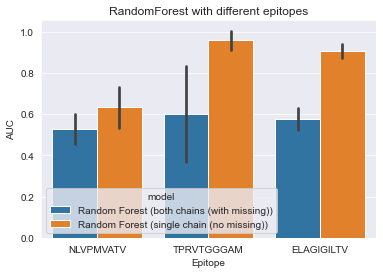

Baseline Random Forest (NaNs dropped in train) not found in scores, using Random Forest (both chains (with missing)) instead


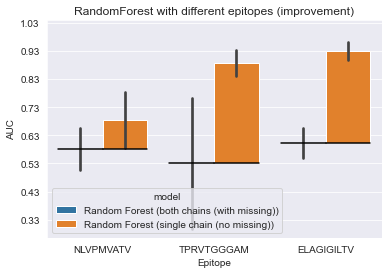

In [40]:
# plot the results
title = "RandomForest with different epitopes"
output = "graphs/rf-different-epitopes-single-chain.png"
plot_scores(df, title, wrap=True, x="epitope", hue="model", xlabel="Epitope", ylabel="AUC",
            output_file=output,
            plot=True)

In [41]:
# mean values per epitope
df.groupby(['epitope', 'drop_train_nan']).mean().reset_index()

,epitope,drop_train_nan,seed,auc,alpha_only_count_pos,beta_only_count_pos,both_count_pos,non_count_pos,a_frac,b_frac,both_frac,non_frac,auc_alpha,auc_beta,improvement_hue
0,ELAGIGILTV,False,2.0,0.905051,0.6,1003.6,195.8,0.0,0.000500,0.836333,0.163167,0.0,NaN,NaN,3.275415e-01
1,ELAGIGILTV,True,2.0,0.577510,0.6,1003.6,195.8,0.0,0.000500,0.836333,0.163167,0.0,0.531535,0.577510,0.000000e+00
2,NLVPMVATV,False,2.0,0.632119,351.2,764.4,84.4,0.0,0.292667,0.637000,0.070333,0.0,NaN,NaN,1.045253e-01
3,NLVPMVATV,True,2.0,0.527594,351.2,764.4,84.4,0.0,0.292667,0.637000,0.070333,0.0,0.421825,0.378574,1.110223e-17
4,TPRVTGGGAM,False,2.0,0.958465,6.8,481.0,102.2,0.0,0.011525,0.815254,0.173220,0.0,NaN,NaN,3.582167e-01
5,TPRVTGGGAM,True,2.0,0.600249,6.8,481.0,102.2,0.0,0.011525,0.815254,0.173220,0.0,0.497105,0.446044,4.440892e-17


In [42]:
df_rf = df
# Create a table with the means
df_rf_means = df_rf.groupby(['epitope', 'drop_train_nan']).mean().reset_index()
# create a dataframe containing the improvements in auc (which is the drop_train_nan=False - drop_train_nan=True)
df_rf_improvements = df_rf_means[df_rf_means.drop_train_nan == False].copy()
df_rf_improvements['auc_improvement'] = df_rf_improvements['auc'] - df_rf_means[df_rf_means.drop_train_nan == True][
    'auc'].values
df_rf_improvements

,epitope,drop_train_nan,seed,auc,alpha_only_count_pos,beta_only_count_pos,both_count_pos,non_count_pos,a_frac,b_frac,both_frac,non_frac,auc_alpha,auc_beta,improvement_hue,auc_improvement
0,ELAGIGILTV,False,2.0,0.905051,0.6,1003.6,195.8,0.0,0.000500,0.836333,0.163167,0.0,NaN,NaN,0.327541,0.327541
2,NLVPMVATV,False,2.0,0.632119,351.2,764.4,84.4,0.0,0.292667,0.637000,0.070333,0.0,NaN,NaN,0.104525,0.104525
4,TPRVTGGGAM,False,2.0,0.958465,6.8,481.0,102.2,0.0,0.011525,0.815254,0.173220,0.0,NaN,NaN,0.358217,0.358217


In [45]:
# based on df_rf_improvement, create a latex table
table = "\\begin{table}[]\n\\centering\n\\begin{tabular}{|l|l|l|l|l|}\n\\hline\n\\textbf{Epitope} & \\textbf{Alpha only} & \\textbf{Beta only} & \\textbf{Both} & \\textbf{Total} \\\\ \\hline\n"
for index, row in df_rf_improvements.iterrows():
    table += f"{row['epitope']} & {row['alpha_only_count_pos']} ({row['a_frac']:.0%}) & {row['beta_only_count_pos']} ({row['b_frac']:.0%}) & {row['both_count_pos']} ({row['both_frac']:.0%}) & {row['alpha_only_count_pos'] + row['beta_only_count_pos'] + row['both_count_pos']} \\\\ \\hline\n"
table += "\\end{tabular}\n\\caption{Distribution of missing data in the different selected epitopes.}\n\\label{table:diff_epitope}\n\\end{table}"
print(table)

\begin{table}[]
\centering
\begin{tabular}{|l|l|l|l|l|}
\hline
\textbf{Epitope} & \textbf{Alpha only} & \textbf{Beta only} & \textbf{Both} & \textbf{Total} \\ \hline
ELAGIGILTV & 0.6 (0%) & 1003.6 (84%) & 195.8 (16%) & 1200.0 \\ \hline
NLVPMVATV & 351.2 (29%) & 764.4 (64%) & 84.4 (7%) & 1200.0 \\ \hline
TPRVTGGGAM & 6.8 (1%) & 481.0 (82%) & 102.2 (17%) & 590.0 \\ \hline
\end{tabular}
\caption{Distribution of missing data in the different selected epitopes.}
\label{table:diff_epitope}
\end{table}


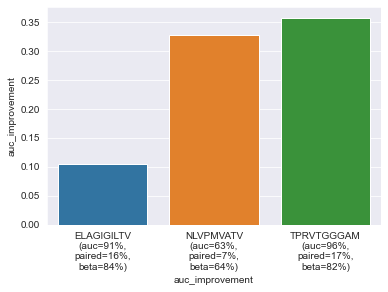

<Figure size 432x288 with 0 Axes>

In [29]:

from matplotlib.ticker import PercentFormatter
# plot the improvements
import seaborn as sns
import matplotlib.pyplot as plt
from util import wrap_labels

# title = "RandomForest with different epitopes"
#
# output = "graphs/rf-different-epitopes-improvements.png"
for x in ['auc_improvement']:
    plot = sns.barplot(data=df_rf_improvements, x=x, y="auc_improvement")
    # rotate xticklabels 90 degrees
    plt.xticks(rotation=0)
    # wrap the xticklabels
    # make percentages from xticks
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # change the x ticks to the epitope names with their original auc (drop train nan = True) between brackets
    plt.xticks(range(len(df_rf_improvements)),
               [f"{epitope} (auc={auc:.0%}, paired={both:.0%}, beta={beta:.0%})" for epitope, auc, both, beta in
                zip(df_rf_improvements['epitope'], df_rf_improvements['auc'],
                    df_rf_improvements['both_frac'],
                    df_rf_improvements['b_frac'])])

    wrap_labels(plot, 11)
    # save the plot
    plt.savefig("graphs/diff-epi-chains.png", bbox_inches='tight')
    plt.show()
    plt.clf()